### PROJET 7
#### Scénario
Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.

Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.

L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne.

Très bien.

"Quelles informations avons-nous ?" demandez-vous à votre supérieur, qui vous répond : "À vrai dire... quasiment aucune : uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. C'est tout ! Ah oui, une dernière chose : ce modèle doit être valable pour la plupart des pays du monde. Je vous laisse méditer là-dessus… Bon courage !"

Avec aussi peu de données disponibles, cela semble être un sacré challenge !

Ainsi, vous proposez une régression linéaire avec 3 variables :

le revenu des parents ;
le revenu moyen du pays dans lequel habite le prospect ;
l'indice de Gini calculé sur les revenus des habitants du pays en question. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as st
import matplotlib.pyplot as plt
import re

In [2]:
base = pd.read_csv('Data_P7.csv') 


le fichier contient les données de la World Income Distribution, datée de 2008.
Cette base de données est composée principalement d'études réalisées au niveau national pour bon nombre de pays, et contient les distributions de revenus des populations concernées.
'gdpppp' signifie le PIB basé sur la parité de pouvoir d'achat.

In [3]:
base

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297
...,...,...,...,...,...,...
11594,COD,2008,96,100,"810,6233","303,19305"
11595,COD,2008,97,100,"911,7834","303,19305"
11596,COD,2008,98,100,"1057,8074","303,19305"
11597,COD,2008,99,100,"1286,6029","303,19305"


###### Nettoyage de la base data

In [4]:
base.year_survey.unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004], dtype=int64)

In [5]:
len(base.country.unique()) # 116 pays

116

In [6]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       11599 non-null  object
 1   year_survey   11599 non-null  int64 
 2   quantile      11599 non-null  int64 
 3   nb_quantiles  11599 non-null  int64 
 4   income        11599 non-null  object
 5   gdpppp        11399 non-null  object
dtypes: int64(3), object(3)
memory usage: 543.8+ KB


In [7]:
# le revenu est de type objet. nous allons le convertir en float pour permettre les calcul
base["income"]=base["income"].astype("string")
base["income"]= base["income"].convert_dtypes()
base["income"]

0        728,89795
1        916,66235
2         1010,916
3        1086,9078
4        1132,6997
           ...    
11594     810,6233
11595     911,7834
11596    1057,8074
11597    1286,6029
11598    2243,1226
Name: income, Length: 11599, dtype: string

In [8]:
### 
base["income"]=base["income"].str.replace(',','.')
base["income"]=base["income"].astype("float")
base["income"]

0         728.89795
1         916.66235
2        1010.91600
3        1086.90780
4        1132.69970
            ...    
11594     810.62330
11595     911.78340
11596    1057.80740
11597    1286.60290
11598    2243.12260
Name: income, Length: 11599, dtype: float64

In [9]:
# meme chose avec le gdppp: nous allons le convertir en float pour permettre les calcul
base["gdpppp"]=base["gdpppp"].astype("string")
base["gdpppp"]= base["gdpppp"].convert_dtypes()
base["gdpppp"]=base["gdpppp"].str.replace(',','.') 
#base["gdpppp"]=base["gdpppp"].astype("float")
base["gdpppp"]
# il ya des NAN qui empeche le processus, nous allons netoyer et revenir contenuer la convertion en float apres

0             7297
1             7297
2             7297
3             7297
4             7297
           ...    
11594    303.19305
11595    303.19305
11596    303.19305
11597    303.19305
11598    303.19305
Name: gdpppp, Length: 11599, dtype: string

In [10]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11599 non-null  object 
 1   year_survey   11599 non-null  int64  
 2   quantile      11599 non-null  int64  
 3   nb_quantiles  11599 non-null  int64  
 4   income        11599 non-null  float64
 5   gdpppp        11399 non-null  string 
dtypes: float64(1), int64(3), object(1), string(1)
memory usage: 543.8+ KB


In [11]:
base.nunique()

country           116
year_survey         7
quantile          100
nb_quantiles        1
income          11598
gdpppp            114
dtype: int64

on a 116 pays avec 100 quantiles par pays. on devrait donc avoir 11600 lignes.
de plus le gdppp , on a 114 valeur contre 116 pays. on a donc 2 pays sans gdppp.
nous allors trouver l'emplacement des données manquant et les remplir par la methode par imputation ou en cherchant la réponse ailleurs

In [12]:
base=base.reset_index()
base

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,0,ALB,2008,1,100,728.89795,7297
1,1,ALB,2008,2,100,916.66235,7297
2,2,ALB,2008,3,100,1010.91600,7297
3,3,ALB,2008,4,100,1086.90780,7297
4,4,ALB,2008,5,100,1132.69970,7297
...,...,...,...,...,...,...,...
11594,11594,COD,2008,96,100,810.62330,303.19305
11595,11595,COD,2008,97,100,911.78340,303.19305
11596,11596,COD,2008,98,100,1057.80740,303.19305
11597,11597,COD,2008,99,100,1286.60290,303.19305


In [13]:
X=base.groupby("quantile").count()
X.loc[X["country"]==115]

,index,country,year_survey,nb_quantiles,income,gdpppp
quantile,,,,,,
41,115,115,115,115,115,113


In [14]:
Y = base.groupby("country").count() 
Y.loc[Y["quantile"]==99]

,index,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,,
LTU,99,99,99,99,99,99


In [15]:
# la lutuanie compte 99 quantiles au lieu de 100 et le quantile manquand est la quantile 41

In [16]:
base_LTU = base.loc[base["country"]=="LTU"] # les données sur la luatuanie
base_LTU.loc[base_LTU["quantile"]== 41] # pas de quntile 41, toute la ligne est manquante

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp


In [17]:
# nous allons calculer les valeur pour cette ligne manquante et l'inserer apres
# calcul du revenu income, (les autres valeur, pays, année, etc, non pas besoin de calcul)
# pour cela, nous allons faire une imputation et la remplacer par la moyenne des valeur du revenu pour les quantile 40 et 42
Z = base_LTU.loc[(base_LTU["quantile"]== 40)|(base_LTU["quantile"]== 42)]
Z

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp
6239,6239,LTU,2008,40,100,4868.4507,17571
6240,6240,LTU,2008,42,100,4895.8306,17571


In [18]:
Z.income.mean()

4882.14065

In [19]:
# creation d'un dataframe à une ligne

df = pd.DataFrame([[6240,"LTU",2008, 41, 100, 4882.14065, 17571]], columns=list('ABCDEFG'), index=[6240])
df
df.columns=["index","country", "year_survey", "quantile", "nb_quantiles", "income","gdpppp"]
df


,index,country,year_survey,quantile,nb_quantiles,income,gdpppp
6240,6240,LTU,2008,41,100,4882.14065,17571


In [20]:
# ajout de df à notre base data
# on peut aussi utiliser le pd.concat
data_essaie=base.append(df, ignore_index=False)
data_essaie = data_essaie.sort_values(by="index")
data_essaie 

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,0,ALB,2008,1,100,728.89795,7297
1,1,ALB,2008,2,100,916.66235,7297
2,2,ALB,2008,3,100,1010.91600,7297
3,3,ALB,2008,4,100,1086.90780,7297
4,4,ALB,2008,5,100,1132.69970,7297
...,...,...,...,...,...,...,...
11594,11594,COD,2008,96,100,810.62330,303.19305
11595,11595,COD,2008,97,100,911.78340,303.19305
11596,11596,COD,2008,98,100,1057.80740,303.19305
11597,11597,COD,2008,99,100,1286.60290,303.19305


In [21]:
data_essaie = data_essaie.drop(columns="index")


In [22]:
data_essaie = data_essaie.reset_index(drop=True)
data_essaie

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297
1,ALB,2008,2,100,916.66235,7297
2,ALB,2008,3,100,1010.91600,7297
3,ALB,2008,4,100,1086.90780,7297
4,ALB,2008,5,100,1132.69970,7297
...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305
11596,COD,2008,97,100,911.78340,303.19305
11597,COD,2008,98,100,1057.80740,303.19305
11598,COD,2008,99,100,1286.60290,303.19305


In [23]:
# verification
data_essaie.loc[(data_essaie["country"]=="LTU")&(data_essaie["quantile"]== 42)]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6241,LTU,2008,42,100,4895.8306,17571


In [24]:
# traitement de donnes manquante sur le gdpppp
data_miss = data_essaie[data_essaie.gdpppp.isna()]
data_miss

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,437.89370,<NA>
5801,XKX,2008,2,100,508.17133,<NA>
5802,XKX,2008,3,100,591.82820,<NA>
5803,XKX,2008,4,100,668.00000,<NA>
5804,XKX,2008,5,100,730.40220,<NA>
...,...,...,...,...,...,...
11295,PSE,2009,96,100,2763.88480,<NA>
11296,PSE,2009,97,100,3077.83330,<NA>
11297,PSE,2009,98,100,3449.22240,<NA>
11298,PSE,2009,99,100,4165.99700,<NA>


il manque le gdp pour le kosovo en 2008 et la West Bank and Gaza en 2009
il nous  consultons les donnés de la banque mondiales

7249.4 pour le kosovo
3708.7 pour  la la West Bank and Gaza

In [25]:
#une nvel base sans les pays ayant un gdppp manquant
data = data_essaie[~data_essaie["country"].isin(["XKX","PSE"])]


In [26]:
#verification
data[data.gdpppp.isna()]

,country,year_survey,quantile,nb_quantiles,income,gdpppp


In [27]:
# creation à part de table pour remplacer les donnés manquant
data_miss_XKX = data_miss.loc[data_miss["country"]=="XKX"]
data_miss_PSE = data_miss.loc[data_miss["country"]=="PSE"]
data_miss_XKX = data_miss_XKX.fillna(value={"gdpppp": 7249.4})
data_miss_PSE = data_miss_PSE.fillna(value={"gdpppp": 3708.7})
data_miss_XKX

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,437.89370,7249.4
5801,XKX,2008,2,100,508.17133,7249.4
5802,XKX,2008,3,100,591.82820,7249.4
5803,XKX,2008,4,100,668.00000,7249.4
5804,XKX,2008,5,100,730.40220,7249.4
...,...,...,...,...,...,...
5895,XKX,2008,96,100,5155.36470,7249.4
5896,XKX,2008,97,100,5689.52930,7249.4
5897,XKX,2008,98,100,6233.73930,7249.4
5898,XKX,2008,99,100,7366.67700,7249.4


In [28]:
data_miss_PSE

,country,year_survey,quantile,nb_quantiles,income,gdpppp
11200,PSE,2009,1,100,195.28990,3708.7
11201,PSE,2009,2,100,264.36533,3708.7
11202,PSE,2009,3,100,301.44672,3708.7
11203,PSE,2009,4,100,329.83392,3708.7
11204,PSE,2009,5,100,348.76495,3708.7
...,...,...,...,...,...,...
11295,PSE,2009,96,100,2763.88480,3708.7
11296,PSE,2009,97,100,3077.83330,3708.7
11297,PSE,2009,98,100,3449.22240,3708.7
11298,PSE,2009,99,100,4165.99700,3708.7


In [29]:
data = data.append(data_miss_PSE,ignore_index=False)


In [30]:
data = data.append(data_miss_XKX,ignore_index=False)
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297
1,ALB,2008,2,100,916.66235,7297
2,ALB,2008,3,100,1010.91600,7297
3,ALB,2008,4,100,1086.90780,7297
4,ALB,2008,5,100,1132.69970,7297
...,...,...,...,...,...,...
5895,XKX,2008,96,100,5155.36470,7249.4
5896,XKX,2008,97,100,5689.52930,7249.4
5897,XKX,2008,98,100,6233.73930,7249.4
5898,XKX,2008,99,100,7366.67700,7249.4


In [31]:
data = data.reset_index()
data = data.sort_values(by="index")
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,0,ALB,2008,1,100,728.89795,7297
1,1,ALB,2008,2,100,916.66235,7297
2,2,ALB,2008,3,100,1010.91600,7297
3,3,ALB,2008,4,100,1086.90780,7297
4,4,ALB,2008,5,100,1132.69970,7297
...,...,...,...,...,...,...,...
11395,11595,COD,2008,96,100,810.62330,303.19305
11396,11596,COD,2008,97,100,911.78340,303.19305
11397,11597,COD,2008,98,100,1057.80740,303.19305
11398,11598,COD,2008,99,100,1286.60290,303.19305


In [32]:
data = data.drop(columns="index")
data = data.reset_index(drop = True)
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297
1,ALB,2008,2,100,916.66235,7297
2,ALB,2008,3,100,1010.91600,7297
3,ALB,2008,4,100,1086.90780,7297
4,ALB,2008,5,100,1132.69970,7297
...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305
11596,COD,2008,97,100,911.78340,303.19305
11597,COD,2008,98,100,1057.80740,303.19305
11598,COD,2008,99,100,1286.60290,303.19305


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11600 non-null  object 
 1   year_survey   11600 non-null  int64  
 2   quantile      11600 non-null  int64  
 3   nb_quantiles  11600 non-null  int64  
 4   income        11600 non-null  float64
 5   gdpppp        11600 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 543.9+ KB


In [34]:
# convertisson le type du gdpppp en float
data["gdpppp"]=data["gdpppp"].astype("string")
data["gdpppp"]= data["gdpppp"].convert_dtypes()
data["gdpppp"]=data["gdpppp"].str.replace(',','.') 
data["gdpppp"]=data["gdpppp"].astype("float")
data["gdpppp"]

0        7297.00000
1        7297.00000
2        7297.00000
3        7297.00000
4        7297.00000
            ...    
11595     303.19305
11596     303.19305
11597     303.19305
11598     303.19305
11599     303.19305
Name: gdpppp, Length: 11600, dtype: float64

#### Ajout d'une base population et nettoyage

In [35]:
pop = pd.read_csv('pop_P7_WB.csv', sep=",") # fichier population telechargé sur le site de la banque mondiale
pop


,Time,Time Code,Country Name,Country Code,"Population, total [SP.POP.TOTL]"
0,2004,YR2004,Afghanistan,AFG,24726689
1,2004,YR2004,Albania,ALB,3026939
2,2004,YR2004,Algeria,DZA,32692153
3,2004,YR2004,American Samoa,ASM,59684
4,2004,YR2004,Andorra,AND,76250
...,...,...,...,...,...
2128,NaN,NaN,NaN,NaN,NaN
2129,NaN,NaN,NaN,NaN,NaN
2130,NaN,NaN,NaN,NaN,NaN
2131,Data from database: World Development Indicators,NaN,NaN,NaN,NaN


In [36]:
pop = pop.reset_index()
pop

,index,Time,Time Code,Country Name,Country Code,"Population, total [SP.POP.TOTL]"
0,0,2004,YR2004,Afghanistan,AFG,24726689
1,1,2004,YR2004,Albania,ALB,3026939
2,2,2004,YR2004,Algeria,DZA,32692153
3,3,2004,YR2004,American Samoa,ASM,59684
4,4,2004,YR2004,Andorra,AND,76250
...,...,...,...,...,...,...
2128,2128,NaN,NaN,NaN,NaN,NaN
2129,2129,NaN,NaN,NaN,NaN,NaN
2130,2130,NaN,NaN,NaN,NaN,NaN
2131,2131,Data from database: World Development Indicators,NaN,NaN,NaN,NaN


In [37]:
pop = pop.drop(columns = ["index","Time Code"])
pop.head()

,Time,Country Name,Country Code,"Population, total [SP.POP.TOTL]"
0,2004,Afghanistan,AFG,24726689
1,2004,Albania,ALB,3026939
2,2004,Algeria,DZA,32692153
3,2004,American Samoa,ASM,59684
4,2004,Andorra,AND,76250


In [38]:
pop = pop.rename(columns={"Country Code":"country", "Population, total [SP.POP.TOTL]":"population", "Time":"year_survey"})
pop.head()

,year_survey,Country Name,country,population
0,2004,Afghanistan,AFG,24726689
1,2004,Albania,ALB,3026939
2,2004,Algeria,DZA,32692153
3,2004,American Samoa,ASM,59684
4,2004,Andorra,AND,76250


In [39]:
pop.sort_values(by="year_survey", ascending=False)

,year_survey,Country Name,country,population
2132,Last Updated: 09/15/2021,NaN,NaN,NaN
2131,Data from database: World Development Indicators,NaN,NaN,NaN
1953,2011,"Iran, Islamic Rep.",IRN,74634959
1947,2011,Honduras,HND,8480670
1948,2011,"Hong Kong SAR, China",HKG,7071600
...,...,...,...,...
170,2004,Sierra Leone,SLE,5433995
0,2004,Afghanistan,AFG,24726689
2128,NaN,NaN,NaN,NaN
2129,NaN,NaN,NaN,NaN


In [40]:
pop[pop.population.isna()]

,year_survey,Country Name,country,population
2128,NaN,NaN,NaN,NaN
2129,NaN,NaN,NaN,NaN
2130,NaN,NaN,NaN,NaN
2131,Data from database: World Development Indicators,NaN,NaN,NaN
2132,Last Updated: 09/15/2021,NaN,NaN,NaN


In [41]:
pop= pop.drop([2128,2129,2130,2131,2132])
pop.sort_values(by="year_survey")

,year_survey,Country Name,country,population
0,2004,Afghanistan,AFG,24726689
169,2004,Seychelles,SYC,82475
170,2004,Sierra Leone,SLE,5433995
171,2004,Singapore,SGP,4166664
172,2004,Sint Maarten (Dutch part),SXM,32488
...,...,...,...,...
1956,2011,Isle of Man,IMN,84889
1957,2011,Israel,ISR,7765800
1958,2011,Italy,ITA,59379449
1944,2011,Guinea-Bissau,GNB,1562996


In [42]:
pop.year_survey.unique()

array(['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011'],
      dtype=object)

In [43]:
# je transforme en entier
pop["year_survey"] = pop["year_survey"].astype(str).astype(int)

In [44]:
pop.population.unique()

array(['24726689', '3026939', '32692153', ..., '892958422', '2363223603',
       '7002880914'], dtype=object)

In [45]:
# je transforme en entier
pop["population"] = pop["population"].astype(str)

In [46]:
pop["population"] = pop["population"].convert_dtypes()
pop["population"]

0         24726689
1          3026939
2         32692153
3            59684
4            76250
           ...    
2123     893045863
2124     892958422
2125     893045863
2126    2363223603
2127    7002880914
Name: population, Length: 2128, dtype: string

In [47]:
pop["population"] =pd.to_numeric(pop["population"], errors='coerce')
pop["population"]

0       2.472669e+07
1       3.026939e+06
2       3.269215e+07
3       5.968400e+04
4       7.625000e+04
            ...     
2123    8.930459e+08
2124    8.929584e+08
2125    8.930459e+08
2126    2.363224e+09
2127    7.002881e+09
Name: population, Length: 2128, dtype: float64

In [48]:
pop["population"]= pd.to_numeric(pop["population"], errors='coerce').convert_dtypes() 
pop["population"]

0         24726689
1          3026939
2         32692153
3            59684
4            76250
           ...    
2123     893045863
2124     892958422
2125     893045863
2126    2363223603
2127    7002880914
Name: population, Length: 2128, dtype: Int64

In [49]:
pop.population.unique()

<IntegerArray>
[  24726689,    3026939,   32692153,      59684,      76250,   18758138,
      80347,   38491970,    3000715,      98744,
 ...
   26647965,    2241808, 1077841980,  753326898,   35912140, 1661532158,
  893045863,  892958422, 2363223603, 7002880914]
Length: 2105, dtype: Int64

In [50]:
pop.country.unique()

array(['AFG', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'ATG', 'ARG', 'ARM',
       'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR',
       'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA',
       'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN',
       'CYM', 'CAF', 'TCD', 'CHI', 'CHL', 'CHN', 'COL', 'COM', 'COD',
       'COG', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK',
       'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST',
       'SWZ', 'ETH', 'FRO', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GUM', 'GTM',
       'GIN', 'GNB', 'GUY', 'HTI', 'HND', 'HKG', 'HUN', 'ISL', 'IND',
       'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN',
       'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'XKX', 'KWT', 'KGZ',
       'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX',
       'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MRT',
       'MUS', 'MEX',

In [51]:
# nous avons la population mondiale dans le tableau. Nous allons l'extraire
pop_mondiale = pop.loc[pop["country"]=="WLD"]
pop_mondiale=pop_mondiale.drop(columns = "country")
pop_mondiale

,year_survey,Country Name,population
265,2004,World,6431551721
531,2005,World,6511748273
797,2006,World,6592734559
1063,2007,World,6674203697
1329,2008,World,6757020825
1595,2009,World,6839574233
1861,2010,World,6921877071
2127,2011,World,7002880914


In [52]:
pop_mondiale = pop_mondiale.rename(columns={"population":"popu_mondiale"})
pop_mondiale

,year_survey,Country Name,popu_mondiale
265,2004,World,6431551721
531,2005,World,6511748273
797,2006,World,6592734559
1063,2007,World,6674203697
1329,2008,World,6757020825
1595,2009,World,6839574233
1861,2010,World,6921877071
2127,2011,World,7002880914


In [53]:
len(pop.country.unique())

266

In [54]:
len(data.country.unique())

116

In [55]:
# merge des deux table pop et data
data1 = pd.merge(data ,pop, on = ["country","year_survey"],how = "left")
data1

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population
0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314
1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314
...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195


In [56]:
data1[data1.population.isna()]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population
10400,TWN,2008,1,100,3477.1800,25342.0,NaN,<NA>
10401,TWN,2008,2,100,4740.2637,25342.0,NaN,<NA>
10402,TWN,2008,3,100,5331.3013,25342.0,NaN,<NA>
10403,TWN,2008,4,100,5761.6577,25342.0,NaN,<NA>
10404,TWN,2008,5,100,6093.2017,25342.0,NaN,<NA>
...,...,...,...,...,...,...,...,...
10495,TWN,2008,96,100,38123.4600,25342.0,NaN,<NA>
10496,TWN,2008,97,100,41663.7900,25342.0,NaN,<NA>
10497,TWN,2008,98,100,46650.5820,25342.0,NaN,<NA>
10498,TWN,2008,99,100,54016.9920,25342.0,NaN,<NA>


In [57]:
# il manque la population de taiwan en 2008: 23019045
data1 = data1.fillna(value={"population": 23019045})
data1[data1.population.isna()]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population


##### Ajout de l'indice de Gini calculé par la WB

In [58]:
gini = pd.read_csv('gini_P7_WB.csv', sep=",")
gini

,Time,Time Code,Country Name,Country Code,Gini index (World Bank estimate) [SI.POV.GINI]
0,2004,YR2004,Afghanistan,AFG,..
1,2004,YR2004,Albania,ALB,..
2,2004,YR2004,Algeria,DZA,..
3,2004,YR2004,American Samoa,ASM,..
4,2004,YR2004,Andorra,AND,..
...,...,...,...,...,...
1862,NaN,NaN,NaN,NaN,NaN
1863,NaN,NaN,NaN,NaN,NaN
1864,NaN,NaN,NaN,NaN,NaN
1865,Data from database: World Development Indicators,NaN,NaN,NaN,NaN


In [59]:
gini = gini.rename(columns={"Gini index (World Bank estimate) [SI.POV.GINI]":"gini_index", "Time":"year_survey","Country Code":"country"})
gini= gini.drop(columns =["Time Code"])
gini

,year_survey,Country Name,country,gini_index
0,2004,Afghanistan,AFG,..
1,2004,Albania,ALB,..
2,2004,Algeria,DZA,..
3,2004,American Samoa,ASM,..
4,2004,Andorra,AND,..
...,...,...,...,...
1862,NaN,NaN,NaN,NaN
1863,NaN,NaN,NaN,NaN
1864,NaN,NaN,NaN,NaN
1865,Data from database: World Development Indicators,NaN,NaN,NaN


In [60]:
gini[gini.gini_index.isna()]

,year_survey,Country Name,country,gini_index
1862,NaN,NaN,NaN,NaN
1863,NaN,NaN,NaN,NaN
1864,NaN,NaN,NaN,NaN
1865,Data from database: World Development Indicators,NaN,NaN,NaN
1866,Last Updated: 09/15/2021,NaN,NaN,NaN


In [61]:
gini= gini.drop([1862,1863,1864,1865,1866])
gini

,year_survey,Country Name,country,gini_index
0,2004,Afghanistan,AFG,..
1,2004,Albania,ALB,..
2,2004,Algeria,DZA,..
3,2004,American Samoa,ASM,..
4,2004,Andorra,AND,..
...,...,...,...,...
1857,2011,Sub-Saharan Africa,SSF,..
1858,2011,Sub-Saharan Africa (excluding high income),SSA,..
1859,2011,Sub-Saharan Africa (IDA & IBRD countries),TSS,..
1860,2011,Upper middle income,UMC,..


In [62]:
gini.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1862 entries, 0 to 1861
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year_survey   1862 non-null   object
 1   Country Name  1862 non-null   object
 2   country       1862 non-null   object
 3   gini_index    1862 non-null   object
dtypes: object(4)
memory usage: 72.7+ KB


In [63]:
gini["year_survey"] = gini["year_survey"].astype(int)

In [64]:
gini["gini_index"] = gini["gini_index"].astype(str)
gini["gini_index"] = gini["gini_index"].convert_dtypes()
gini["gini_index"]= pd.to_numeric(gini["gini_index"], errors='coerce').convert_dtypes()

In [65]:
gini.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1862 entries, 0 to 1861
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year_survey   1862 non-null   int32  
 1   Country Name  1862 non-null   object 
 2   country       1862 non-null   object 
 3   gini_index    526 non-null    float64
dtypes: float64(1), int32(1), object(2)
memory usage: 65.5+ KB


In [66]:
# merge avec data1
data2 = pd.merge(data1 ,gini, on = ["country","year_survey","Country Name"],how = "left")
data2

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index
0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0
1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN


In [67]:
data2[data2.gini_index.isna()]


,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index
400,AZE,2008,1,100,397.53983,8101.00000,Azerbaijan,8763400,NaN
401,AZE,2008,2,100,597.77320,8101.00000,Azerbaijan,8763400,NaN
402,AZE,2008,3,100,705.47003,8101.00000,Azerbaijan,8763400,NaN
403,AZE,2008,4,100,785.52610,8101.00000,Azerbaijan,8763400,NaN
404,AZE,2008,5,100,841.75244,8101.00000,Azerbaijan,8763400,NaN
...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN


2700 ligne avec des NAN pour l'indice de gini, soit 27 pays sans indice de gini
nous allons donc calculer l'indice

##### Calcul de l'indice de gini

Le coefficient de Gini est une mesure largement utilisée pour rendre compte des inégalités économiques.  Il varie entre 0 (égalité parfaite) et 1 (inégalité extrême). Entre 0 et 1, l'inégalité est d'autant plus forte que l'indice de Gini est élevé.
Il est égal à 0 dans une situation d'égalité parfaite où la variable prend une valeur identique sur l’ensemble de la population. À l'autre extrême, il est égal à 1 dans la situation la plus inégalitaire possible, où la variable vaut 0 sur toute la population à l’exception d’un seul individu. 
il est calculé à travers la courbe de lorrentz:
Si la répartition est parfaitement égalitaire, la courbe est donc confondue avec la première bissectrice mais sinon, elle se situe au-dessous.
si non, il ya un écart entre la premiere bisectrice et la courbe de lorrentz, et cette surface est appellé surface de concentration

Indice de gini = surface de concentration/ aire du triange (qui fait 0,5) = 2 * surface de concentration   

la surface de concentration = l'aire du triange - l'aire sous la courbe  
 
 Indice de gini = =  2 * [0,5 -l'aire sous la courbe]
 
 aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
 
 lorenz = np.cumsum(np.sort(Income)) / Income.sum()
 
 Income = data["income"].values 

In [68]:
income_sum = data2.groupby("country")["income"].sum().reset_index() # calcul somme total des revenus par pays
income_sum = income_sum.rename(columns={"income":"income_sum"})
income_sum

,country,income_sum
0,ALB,2.994830e+05
1,ARG,5.847885e+05
2,ARM,1.628383e+05
3,AUT,1.663760e+06
4,AZE,2.357429e+05
...,...,...
111,VEN,3.167148e+05
112,VNM,1.377774e+05
113,XKX,2.176269e+05
114,YEM,1.042636e+05


In [69]:
data = pd.merge(data2, income_sum, on="country", how='left') # ajout de cette somme à notre base
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index,income_sum
0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,299482.990200
1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,299482.990200
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,299482.990200
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,299482.990200
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,299482.990200
...,...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415


In [70]:
data = data.reset_index()
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index,income_sum
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,299482.990200
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,299482.990200
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,299482.990200
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,299482.990200
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,299482.990200
...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415


In [71]:
income_cumsum = data2.groupby("country")["income"].cumsum().reset_index()#  calcul du revenu cumulé pour chaque  pays
income_cumsum=income_cumsum.rename(columns={"income":"income_cumsum"})
income_cumsum

,index,income_cumsum
0,0,728.897950
1,1,1645.560300
2,2,2656.476300
3,3,3743.384100
4,4,4876.083800
...,...,...
11595,11595,22102.288115
11596,11596,23014.071515
11597,11597,24071.878915
11598,11598,25358.481815


In [72]:
data = pd.merge(data, income_cumsum, on="index", how ="left")# ajout de cette nouvelle variable à notre base
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index,income_sum,income_cumsum
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,299482.990200,728.897950
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,299482.990200,1645.560300
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,299482.990200,2656.476300
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,299482.990200,3743.384100
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,299482.990200,4876.083800
...,...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415,22102.288115
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415,23014.071515
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415,24071.878915
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415,25358.481815


In [73]:
data["lorentz"] = data["income_cumsum"]/data["income_sum"] # revenu cumulé sur la somme de revenu (pourcentages cumulés de revenus)
data.head(100)

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index,income_sum,income_cumsum,lorentz
0,0,ALB,2008,1,100,728.89795,7297.0,Albania,2947314,30.0,299482.9902,728.89795,0.002434
1,1,ALB,2008,2,100,916.66235,7297.0,Albania,2947314,30.0,299482.9902,1645.56030,0.005495
2,2,ALB,2008,3,100,1010.91600,7297.0,Albania,2947314,30.0,299482.9902,2656.47630,0.008870
3,3,ALB,2008,4,100,1086.90780,7297.0,Albania,2947314,30.0,299482.9902,3743.38410,0.012499
4,4,ALB,2008,5,100,1132.69970,7297.0,Albania,2947314,30.0,299482.9902,4876.08380,0.016282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,ALB,2008,96,100,6231.09960,7297.0,Albania,2947314,30.0,299482.9902,257778.70580,0.860746
96,96,ALB,2008,97,100,6822.31840,7297.0,Albania,2947314,30.0,299482.9902,264601.02420,0.883526
97,97,ALB,2008,98,100,7775.89100,7297.0,Albania,2947314,30.0,299482.9902,272376.91520,0.909490
98,98,ALB,2008,99,100,9351.75100,7297.0,Albania,2947314,30.0,299482.9902,281728.66620,0.940717


In [74]:
len(data["lorentz"])

11600

In [75]:
# Pour le calcul de l'aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"

# j'enleve la derniere ligne de chaque groupe .  
data_gini = data[~data ["quantile"].isin([100])]
data_gini.head(101)

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index,income_sum,income_cumsum,lorentz
0,0,ALB,2008,1,100,728.89795,7297.0,Albania,2947314,30.0,299482.99020,728.89795,0.002434
1,1,ALB,2008,2,100,916.66235,7297.0,Albania,2947314,30.0,299482.99020,1645.56030,0.005495
2,2,ALB,2008,3,100,1010.91600,7297.0,Albania,2947314,30.0,299482.99020,2656.47630,0.008870
3,3,ALB,2008,4,100,1086.90780,7297.0,Albania,2947314,30.0,299482.99020,3743.38410,0.012499
4,4,ALB,2008,5,100,1132.69970,7297.0,Albania,2947314,30.0,299482.99020,4876.08380,0.016282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,ALB,2008,97,100,6822.31840,7297.0,Albania,2947314,30.0,299482.99020,264601.02420,0.883526
97,97,ALB,2008,98,100,7775.89100,7297.0,Albania,2947314,30.0,299482.99020,272376.91520,0.909490
98,98,ALB,2008,99,100,9351.75100,7297.0,Albania,2947314,30.0,299482.99020,281728.66620,0.940717
100,100,ARG,2008,1,100,254.08942,13220.0,Argentina,40080159,44.9,584788.46537,254.08942,0.000434


In [76]:
# aire_ss_courbe : somme des pourcentage cumulées sur le nombre de quantile
G = data_gini.groupby("country")["lorentz"].sum().reset_index() # regroupement par pays pour calculer l'aire sous la courbe
G = G.rename(columns={"lorentz":"lorentz_sum"})
G["Aire_sous_Lorentz"] = G["lorentz_sum"]/100 # 100 correspond au nombre de quantile
G

,country,lorentz_sum,Aire_sous_Lorentz
0,ALB,34.268785,0.342688
1,ARG,27.004918,0.270049
2,ARM,36.344619,0.363446
3,AUT,35.586044,0.355860
4,AZE,33.883941,0.338839
...,...,...,...
111,VEN,27.798932,0.277989
112,VNM,30.625952,0.306260
113,XKX,33.776270,0.337763
114,YEM,30.791938,0.307919


In [77]:
# l'indice de gini est egale à 2 multiplié par la surface de concentration et la surface de concentration correspond à la surface entre la premiere bisectrice et la courbe de lorrentz
                      
G["gini_calcul"] = 2*(0.5 - G["Aire_sous_Lorentz"])
gini_calcul = G.drop(columns=["lorentz_sum","Aire_sous_Lorentz"])

gini_calcul
                      

,country,gini_calcul
0,ALB,0.314624
1,ARG,0.459902
2,ARM,0.273108
3,AUT,0.288279
4,AZE,0.322321
...,...,...
111,VEN,0.444021
112,VNM,0.387481
113,XKX,0.324475
114,YEM,0.384161


In [78]:
# merge data et gini calcul
data = pd.merge(data, gini_calcul, on="country", how="left")
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index,income_sum,income_cumsum,lorentz,gini_calcul
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,299482.990200,728.897950,0.002434,0.314624
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,299482.990200,1645.560300,0.005495,0.314624
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,299482.990200,2656.476300,0.008870,0.314624
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,299482.990200,3743.384100,0.012499,0.314624
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,299482.990200,4876.083800,0.016282,0.314624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415,22102.288115,0.800761,0.453997
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415,23014.071515,0.833795,0.453997
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415,24071.878915,0.872119,0.453997
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,27601.604415,25358.481815,0.918732,0.453997


In [79]:
data = data.rename(columns={"gini_index":"gini_index_WB", "gini_calcul":"gini_index"})
data = data.drop(columns=["income_sum","income_cumsum","lorentz"])

In [80]:
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,0.314624
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,0.314624
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,0.314624
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,0.314624
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,0.314624
...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997


#### Mission 1
Résumez les données utilisées :
année(s) des données utilisées ;
nombre de pays présents ;
population couverte par l'analyse (en termes de pourcentage de la population mondiale).

Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective.
De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

(Nous appellerons ici chaque quantile une classe de revenu.
Ainsi, la valeur de la colonne income pour un quantile donné peut être vue comme le revenu moyen des personnes appartenant à la classe de revenu correspondante à ce quantile).

L'unité utilisée dans la colonne income de la world income distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc. Après vous être documenté, vous expliquerez à votre mentor très brièvement à quoi correspond cette unité et pourquoi elle est pertinente pour une comparaison de pays différents (Il n'est pas nécessaire de donner cette explication lors de la soutenance).

In [81]:
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,0.314624
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,0.314624
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,0.314624
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,0.314624
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,0.314624
...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997


In [82]:
data = data.drop_duplicates()
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,0.314624
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,0.314624
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,0.314624
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,0.314624
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,0.314624
...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997


###### Résumez les données utilisées : année(s) des données utilisées ; nombre de pays présents ; population couverte par l'analyse (en termes de pourcentage de la population mondiale).

In [83]:
data.nunique()

index            11600
country            116
year_survey          7
quantile           100
nb_quantiles         1
income           11599
gdpppp             116
Country Name       115
population         116
gini_index_WB       82
gini_index         116
dtype: int64

##### 116 pays, 7 années: de 2004, et 2006 à 2011 , 2005 ne fait pas parti

In [84]:
# calcul population couverte par l'analyse (en termes de pourcentage de la population mondiale).
pop_analyse =pd.DataFrame(data, columns = ["country","year_survey","population"]).drop_duplicates()
pop_analyse

,country,year_survey,population
0,ALB,2008,2947314
100,ARG,2008,40080159
200,ARM,2008,2907615
300,AUT,2008,8321496
400,AZE,2008,8763400
...,...,...,...
11100,VNM,2006,84617545
11200,PSE,2009,3689099
11300,YEM,2008,21892149
11400,ZAF,2008,49779472


In [85]:
pop_analyse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 11500
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      116 non-null    object
 1   year_survey  116 non-null    int64 
 2   population   116 non-null    Int64 
dtypes: Int64(1), int64(1), object(1)
memory usage: 3.7+ KB


In [86]:
pop_analyse = pop_analyse.groupby("year_survey").sum().reset_index()
pop_analyse

,year_survey,population
0,2004,17827827
1,2006,287548007
2,2007,2691886113
3,2008,2326737272
4,2009,466148604
5,2010,383832444
6,2011,14521515


In [87]:
pop_analyse = pop_analyse.rename(columns={"population":"popu_analyse"})

In [88]:
# merge avec la population mondiale
pop_analyse = pd.merge(pop_analyse, pop_mondiale, how = "left", on ="year_survey")
pop_analyse
                         

,year_survey,popu_analyse,Country Name,popu_mondiale
0,2004,17827827,World,6431551721
1,2006,287548007,World,6592734559
2,2007,2691886113,World,6674203697
3,2008,2326737272,World,6757020825
4,2009,466148604,World,6839574233
5,2010,383832444,World,6921877071
6,2011,14521515,World,7002880914


In [89]:
pop_analyse["pop_analyse_pop_mondiale"]=pop_analyse["popu_analyse"]/pop_analyse["popu_mondiale"]*100
pop_analyse

,year_survey,popu_analyse,Country Name,popu_mondiale,pop_analyse_pop_mondiale
0,2004,17827827,World,6431551721,0.277193
1,2006,287548007,World,6592734559,4.361589
2,2007,2691886113,World,6674203697,40.332693
3,2008,2326737272,World,6757020825,34.434366
4,2009,466148604,World,6839574233,6.815462
5,2010,383832444,World,6921877071,5.545207
6,2011,14521515,World,7002880914,0.207365


In [90]:
# la population couverte par l'analyse : 
pop_analyse.pop_analyse_pop_mondiale.sum()

91.97387646359101

###### Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective. De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ? Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

In [91]:
data.loc[(data["year_survey"]== 2008) & (data["country"]=="ALB")]

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index
0,0,ALB,2008,1,100,728.89795,7297.0,Albania,2947314,30.0,0.314624
1,1,ALB,2008,2,100,916.66235,7297.0,Albania,2947314,30.0,0.314624
2,2,ALB,2008,3,100,1010.91600,7297.0,Albania,2947314,30.0,0.314624
3,3,ALB,2008,4,100,1086.90780,7297.0,Albania,2947314,30.0,0.314624
4,4,ALB,2008,5,100,1132.69970,7297.0,Albania,2947314,30.0,0.314624
...,...,...,...,...,...,...,...,...,...,...,...
95,95,ALB,2008,96,100,6231.09960,7297.0,Albania,2947314,30.0,0.314624
96,96,ALB,2008,97,100,6822.31840,7297.0,Albania,2947314,30.0,0.314624
97,97,ALB,2008,98,100,7775.89100,7297.0,Albania,2947314,30.0,0.314624
98,98,ALB,2008,99,100,9351.75100,7297.0,Albania,2947314,30.0,0.314624


100 quantiles , donc des centiles. cent classe de revenu et la population est repartie entre ces 100 classes pour chaque pays et par An 

Oui, l'échantillonnage par les  quantiles est une bonne méthode  parce que

###### L'unité utilisée dans la colonne income de la world income distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc. Après vous être documenté, vous expliquerez à votre mentor très brièvement à quoi correspond cette unité et pourquoi elle est pertinente pour une comparaison de pays différents (Il n'est pas nécessaire de donner cette explication lors de la soutenance).

### Mission 2
Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.

Représentez la courbe de Lorenz de chacun des pays choisis.

Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

In [92]:
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,0.314624
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,0.314624
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,0.314624
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,0.314624
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,0.314624
...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997


In [93]:
from math import log
import math

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11600 entries, 0 to 11599
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          11600 non-null  int64  
 1   country        11600 non-null  object 
 2   year_survey    11600 non-null  int64  
 3   quantile       11600 non-null  int64  
 4   nb_quantiles   11600 non-null  int64  
 5   income         11600 non-null  float64
 6   gdpppp         11600 non-null  float64
 7   Country Name   11500 non-null  object 
 8   population     11600 non-null  Int64  
 9   gini_index_WB  8900 non-null   float64
 10  gini_index     11600 non-null  float64
dtypes: Int64(1), float64(4), int64(4), object(2)
memory usage: 1.1+ MB


In [95]:
data["log_income"] = np.log(data["income"])
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,0.314624,6.591534
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,0.314624,6.820739
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,0.314624,6.918612
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,0.314624,6.991092
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,0.314624,7.032359
...,...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.697803
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.815402
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.963954
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,7.159761


Nous faisons le choix des 5 pays en se referant à l' indices de gini. l'inégalité est d'autant plus forte que l'indice de Gini est élevé.

In [96]:
gini.sort_values(by="gini_index", ascending=False)

,year_survey,Country Name,country,gini_index
1507,2010,South Africa,ZAF,63.4
975,2008,South Africa,ZAF,63.0
1200,2009,Namibia,NAM,61.0
1089,2009,Botswana,BWA,60.5
85,2004,Honduras,HND,58.1
...,...,...,...,...
1857,2011,Sub-Saharan Africa,SSF,NaN
1858,2011,Sub-Saharan Africa (excluding high income),SSA,NaN
1859,2011,Sub-Saharan Africa (IDA & IBRD countries),TSS,NaN
1860,2011,Upper middle income,UMC,NaN


In [97]:
gini.sort_values(by="gini_index")

,year_survey,Country Name,country,gini_index
972,2008,Slovenia,SVN,23.7
706,2007,Slovenia,SVN,24.4
440,2006,Slovenia,SVN,24.4
1799,2011,Ukraine,UKR,24.6
705,2007,Slovak Republic,SVK,24.7
...,...,...,...,...
1857,2011,Sub-Saharan Africa,SSF,NaN
1858,2011,Sub-Saharan Africa (excluding high income),SSA,NaN
1859,2011,Sub-Saharan Africa (IDA & IBRD countries),TSS,NaN
1860,2011,Upper middle income,UMC,NaN


In [98]:
gini.loc[gini["gini_index"]>=40]

,year_survey,Country Name,country,gini_index
7,2004,Argentina,ARG,48.4
23,2004,Bolivia,BOL,55.0
26,2004,Brazil,BRA,56.5
42,2004,Colombia,COL,55.0
43,2004,Comoros,COM,55.9
...,...,...,...,...
1790,2011,Togo,TGO,46.0
1794,2011,Turkey,TUR,40.0
1802,2011,United States,USA,40.9
1803,2011,Uruguay,URY,42.2


In [99]:
# les cinq pays retenus
data_ZAF = data.loc[data["country"]=="ZAF"] # indice de gini de 63
data_USA = data.loc[data["country"]=="USA"] # indice de gini de 40.9
data_BRA = data.loc[data["country"]=="BRA"]  # indice de gini de 56.9
data_ALB = data.loc[data["country"]=="ALB"]   # indice de gini de 30
data_SVN = data.loc[data["country"]=="SVN"]   # indice de gini de 23.7


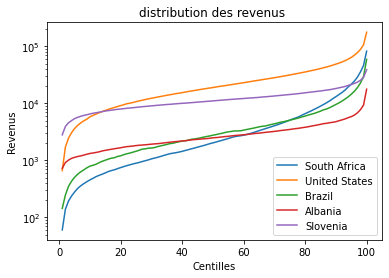

In [100]:
plt.yscale('log') # echelle logarithmique
plt.plot(data_ZAF["quantile"], data_ZAF["income"], label='South Africa')
plt.plot(data_USA["quantile"], data_USA["income"], label='United States')
plt.plot(data_BRA["quantile"], data_BRA["income"], label='Brazil')
plt.plot(data_ALB["quantile"], data_ALB["income"], label='Albania')
plt.plot(data_SVN["quantile"], data_SVN["income"], label='Slovenia')
plt.xlabel('Centilles')
plt.ylabel('Revenus')
plt.title("distribution des revenus ")
plt.legend()
plt.savefig("distribut_rev")

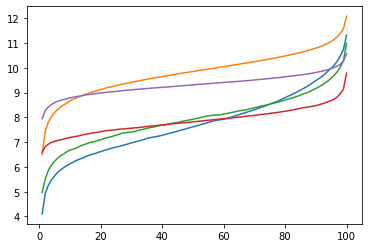

In [101]:
plt.plot(data_ZAF["quantile"], data_ZAF["log_income"], label='South Africa')
plt.plot(data_USA["quantile"], data_USA["log_income"], label='United States')
plt.plot(data_BRA["quantile"], data_BRA["log_income"], label='Brazil')
plt.plot(data_ALB["quantile"], data_ALB["log_income"], label='Albanie')
plt.plot(data_SVN["quantile"], data_SVN["log_income"], label='Slovenie')

##### Courbe de lorentz de chacun de ces pays

In [102]:
#la courbe de lorentz permet de visualiser les concentration de revenu

In [103]:
# la courbe de lorentz pour l'afrique du sud
data_ZAF

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income
11400,11400,ZAF,2008,1,100,60.490383,9602.0,South Africa,49779472,63.0,0.679779,4.102484
11401,11401,ZAF,2008,2,100,138.341550,9602.0,South Africa,49779472,63.0,0.679779,4.929726
11402,11402,ZAF,2008,3,100,192.294500,9602.0,South Africa,49779472,63.0,0.679779,5.259028
11403,11403,ZAF,2008,4,100,236.994000,9602.0,South Africa,49779472,63.0,0.679779,5.468035
11404,11404,ZAF,2008,5,100,279.367580,9602.0,South Africa,49779472,63.0,0.679779,5.632528
...,...,...,...,...,...,...,...,...,...,...,...,...
11495,11495,ZAF,2008,96,100,24553.568000,9602.0,South Africa,49779472,63.0,0.679779,10.108612
11496,11496,ZAF,2008,97,100,28858.031000,9602.0,South Africa,49779472,63.0,0.679779,10.270144
11497,11497,ZAF,2008,98,100,35750.290000,9602.0,South Africa,49779472,63.0,0.679779,10.484314
11498,11498,ZAF,2008,99,100,46297.316000,9602.0,South Africa,49779472,63.0,0.679779,10.742839


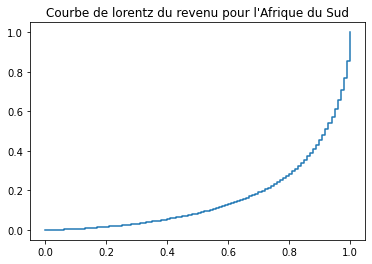

In [104]:
# la courbe de lorrentz pour l'afrique du sud
Income = data_ZAF["income"].values
lorenz_1 = np.cumsum(np.sort(Income)) / Income.sum()
lorenz_1 = np.append([0],lorenz_1) # La courbe de Lorenz commence à 0
plt.plot(np.linspace(0,1,len(lorenz_1)),lorenz_1,drawstyle='steps-post')
plt.title("Courbe de lorentz du revenu pour l'Afrique du Sud")
plt.savefig("lorentz_1.png")

In [105]:
data_USA

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income
10900,10900,USA,2008,1,100,663.4761,43261.0,United States,304093966,40.8,0.441799,6.497493
10901,10901,USA,2008,2,100,1698.0868,43261.0,United States,304093966,40.8,0.441799,7.437257
10902,10902,USA,2008,3,100,2439.7354,43261.0,United States,304093966,40.8,0.441799,7.799645
10903,10903,USA,2008,4,100,3054.2478,43261.0,United States,304093966,40.8,0.441799,8.024289
10904,10904,USA,2008,5,100,3627.5483,43261.0,United States,304093966,40.8,0.441799,8.196312
...,...,...,...,...,...,...,...,...,...,...,...,...
10995,10995,USA,2008,96,100,69926.3700,43261.0,United States,304093966,40.8,0.441799,11.155198
10996,10996,USA,2008,97,100,77634.8200,43261.0,United States,304093966,40.8,0.441799,11.259771
10997,10997,USA,2008,98,100,88482.8400,43261.0,United States,304093966,40.8,0.441799,11.390564
10998,10998,USA,2008,99,100,106765.2600,43261.0,United States,304093966,40.8,0.441799,11.578388


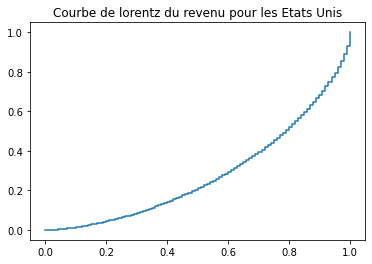

In [106]:
# la courbe de lorrentz pour les Etats Unis
Income = data_USA["income"].values
lorenz_2 = np.cumsum(np.sort(Income)) / Income.sum()
lorenz_2 = np.append([0],lorenz_2) # La courbe de Lorenz commence à 0
plt.plot(np.linspace(0,1,len(lorenz_2)),lorenz_2,drawstyle='steps-post')
plt.title("Courbe de lorentz du revenu pour les Etats Unis")
plt.savefig("lorentz_2.png")

In [107]:
data_BRA

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income
1200,1200,BRA,2008,1,100,144.02846,9559.0,Brazil,192030362,54.0,0.554494,4.970011
1201,1201,BRA,2008,2,100,245.92259,9559.0,Brazil,192030362,54.0,0.554494,5.505017
1202,1202,BRA,2008,3,100,347.86597,9559.0,Brazil,192030362,54.0,0.554494,5.851817
1203,1203,BRA,2008,4,100,430.76090,9559.0,Brazil,192030362,54.0,0.554494,6.065553
1204,1204,BRA,2008,5,100,506.10590,9559.0,Brazil,192030362,54.0,0.554494,6.226746
...,...,...,...,...,...,...,...,...,...,...,...,...
1295,1295,BRA,2008,96,100,16323.82100,9559.0,Brazil,192030362,54.0,0.554494,9.700381
1296,1296,BRA,2008,97,100,18917.69100,9559.0,Brazil,192030362,54.0,0.554494,9.847853
1297,1297,BRA,2008,98,100,22820.66800,9559.0,Brazil,192030362,54.0,0.554494,10.035422
1298,1298,BRA,2008,99,100,29642.62000,9559.0,Brazil,192030362,54.0,0.554494,10.296968


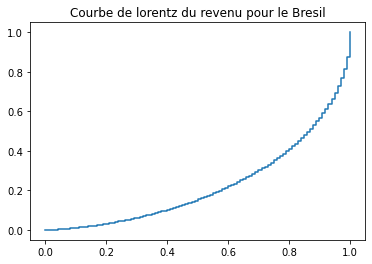

In [108]:
# la courbe de lorrentz pour le Bresil
Income = data_BRA["income"].values
lorenz_3 = np.cumsum(np.sort(Income)) / Income.sum()
lorenz_3 = np.append([0],lorenz_3) # La courbe de Lorenz commence à 0
plt.plot(np.linspace(0,1,len(lorenz_3)),lorenz_3,drawstyle='steps-post')
plt.title("Courbe de lorentz du revenu pour le Bresil")
plt.savefig("lorentz_3.png")

In [109]:
data_ALB

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income
0,0,ALB,2008,1,100,728.89795,7297.0,Albania,2947314,30.0,0.314624,6.591534
1,1,ALB,2008,2,100,916.66235,7297.0,Albania,2947314,30.0,0.314624,6.820739
2,2,ALB,2008,3,100,1010.91600,7297.0,Albania,2947314,30.0,0.314624,6.918612
3,3,ALB,2008,4,100,1086.90780,7297.0,Albania,2947314,30.0,0.314624,6.991092
4,4,ALB,2008,5,100,1132.69970,7297.0,Albania,2947314,30.0,0.314624,7.032359
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,ALB,2008,96,100,6231.09960,7297.0,Albania,2947314,30.0,0.314624,8.737308
96,96,ALB,2008,97,100,6822.31840,7297.0,Albania,2947314,30.0,0.314624,8.827955
97,97,ALB,2008,98,100,7775.89100,7297.0,Albania,2947314,30.0,0.314624,8.958783
98,98,ALB,2008,99,100,9351.75100,7297.0,Albania,2947314,30.0,0.314624,9.143319


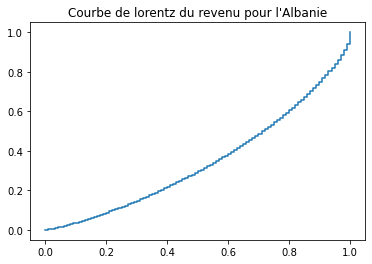

In [110]:
# la courbe de lorrentz pour l'Albanie
Income = data_ALB["income"].values
lorenz_4 = np.cumsum(np.sort(Income)) / Income.sum()
lorenz_4 = np.append([0],lorenz_4) # La courbe de Lorenz commence à 0
plt.plot(np.linspace(0,1,len(lorenz_4)),lorenz_4,drawstyle='steps-post')
plt.title("Courbe de lorentz du revenu pour l'Albanie")
plt.savefig("lorentz_4.png")

In [111]:
data_SVN

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income
9600,9600,SVN,2008,1,100,2814.9530,27197.0,Slovenia,2021316,23.7,0.240731,7.942701
9601,9601,SVN,2008,2,100,3924.2173,27197.0,Slovenia,2021316,23.7,0.240731,8.274922
9602,9602,SVN,2008,3,100,4551.5674,27197.0,Slovenia,2021316,23.7,0.240731,8.423227
9603,9603,SVN,2008,4,100,4987.3280,27197.0,Slovenia,2021316,23.7,0.240731,8.514656
9604,9604,SVN,2008,5,100,5399.6714,27197.0,Slovenia,2021316,23.7,0.240731,8.594093
...,...,...,...,...,...,...,...,...,...,...,...,...
9695,9695,SVN,2008,96,100,22362.0600,27197.0,Slovenia,2021316,23.7,0.240731,10.015121
9696,9696,SVN,2008,97,100,23563.5530,27197.0,Slovenia,2021316,23.7,0.240731,10.067456
9697,9697,SVN,2008,98,100,25440.1700,27197.0,Slovenia,2021316,23.7,0.240731,10.144085
9698,9698,SVN,2008,99,100,28644.8610,27197.0,Slovenia,2021316,23.7,0.240731,10.262729


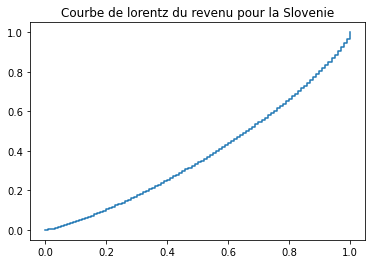

In [112]:
# la courbe de lorrentz pour la Slovenie
Income = data_SVN["income"].values
lorenz_5 = np.cumsum(np.sort(Income)) / Income.sum()
lorenz_5 = np.append([0],lorenz_5) # La courbe de Lorenz commence à 0
plt.plot(np.linspace(0,1,len(lorenz_5)),lorenz_5,drawstyle='steps-post')
plt.title("Courbe de lorentz du revenu pour la Slovenie")
plt.savefig("lorentz_5.png")

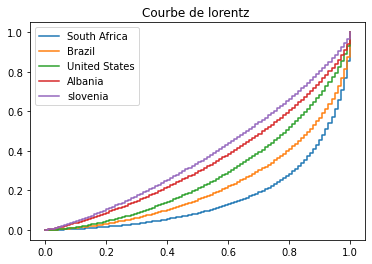

In [113]:
plt.plot(np.linspace(0,1,len(lorenz_1)),lorenz_1,drawstyle='steps-post', label='South Africa')
plt.plot(np.linspace(0,1,len(lorenz_3)),lorenz_3,drawstyle='steps-post', label='Brazil')
plt.plot(np.linspace(0,1,len(lorenz_2)),lorenz_2,drawstyle='steps-post',label='United States')
plt.plot(np.linspace(0,1,len(lorenz_4)),lorenz_4,drawstyle='steps-post',label='Albania')
plt.plot(np.linspace(0,1,len(lorenz_5)),lorenz_5,drawstyle='steps-post',label='slovenia')
plt.title("Courbe de lorentz ")
plt.legend()
plt.savefig("courbe_lorentz_all")

##### Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans

In [114]:
# affiche l'indice de genie sur une longue periode
gini_gb = pd.read_csv('GINI_GBL_WB.csv', sep=",")
gini_gb

,Time,Time Code,Country Name,Country Code,Gini index (World Bank estimate) [SI.POV.GINI]
0,1960,YR1960,Afghanistan,AFG,..
1,1960,YR1960,Albania,ALB,..
2,1960,YR1960,Algeria,DZA,..
3,1960,YR1960,American Samoa,ASM,..
4,1960,YR1960,Andorra,AND,..
...,...,...,...,...,...
13237,NaN,NaN,NaN,NaN,NaN
13238,NaN,NaN,NaN,NaN,NaN
13239,NaN,NaN,NaN,NaN,NaN
13240,Data from database: World Development Indicators,NaN,NaN,NaN,NaN


In [115]:
gini_gb = gini_gb.rename(columns={"Gini index (World Bank estimate) [SI.POV.GINI]":"gini_index", "Time":"year_survey","Country Code":"country"})
gini_gb= gini_gb.drop(columns =["Time Code"])
gini_gb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13242 entries, 0 to 13241
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year_survey   13239 non-null  object
 1   Country Name  13237 non-null  object
 2   country       13237 non-null  object
 3   gini_index    13237 non-null  object
dtypes: object(4)
memory usage: 413.9+ KB


In [116]:
gini_gb["gini_index"] = gini_gb["gini_index"].astype(str)
gini_gb["gini_index"] = gini_gb["gini_index"].convert_dtypes()
gini_gb["gini_index"]= pd.to_numeric(gini_gb["gini_index"], errors='coerce').convert_dtypes()
gini_gb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13242 entries, 0 to 13241
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year_survey   13239 non-null  object 
 1   Country Name  13237 non-null  object 
 2   country       13237 non-null  object 
 3   gini_index    1745 non-null   float64
dtypes: float64(1), object(3)
memory usage: 413.9+ KB


In [117]:
gini_gb["year_survey"] = gini_gb["year_survey"].astype(str)
gini_gb["year_survey"] = gini_gb["year_survey"].convert_dtypes()
gini_gb["year_survey"] = pd.to_numeric(gini_gb["year_survey"], errors='coerce').convert_dtypes()
gini_gb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13242 entries, 0 to 13241
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year_survey   13237 non-null  Int64  
 1   Country Name  13237 non-null  object 
 2   country       13237 non-null  object 
 3   gini_index    1745 non-null   float64
dtypes: Int64(1), float64(1), object(2)
memory usage: 426.9+ KB


In [118]:
gini_gb.year_survey.unique()

<IntegerArray>
[1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, <NA>]
Length: 62, dtype: Int64

In [119]:
Gini_ZAF = gini_gb.loc[gini_gb["country"]=="ZAF"].dropna()
Gini_ZAF

,year_survey,Country Name,country,gini_index
7338,1993,South Africa,ZAF,59.3
7989,1996,South Africa,ZAF,60.7
8857,2000,South Africa,ZAF,57.8
9942,2005,South Africa,ZAF,64.8
10593,2008,South Africa,ZAF,63.0
11027,2010,South Africa,ZAF,63.4
11895,2014,South Africa,ZAF,63.0


In [120]:
Gini_BRA= gini_gb.loc[gini_gb["country"]=="BRA"].dropna()
Gini_BRA

,year_survey,Country Name,country,gini_index
4583,1981,Brazil,BRA,57.9
4800,1982,Brazil,BRA,58.4
5017,1983,Brazil,BRA,59.0
5234,1984,Brazil,BRA,58.4
5451,1985,Brazil,BRA,55.6
5668,1986,Brazil,BRA,58.5
5885,1987,Brazil,BRA,59.7
6102,1988,Brazil,BRA,61.4
6319,1989,Brazil,BRA,63.3
6536,1990,Brazil,BRA,60.5


In [121]:
Gini_USA= gini_gb.loc[gini_gb["country"]=="USA"].dropna()
Gini_USA

,year_survey,Country Name,country,gini_index
3244,1974,United States,USA,35.3
4329,1979,United States,USA,34.5
5848,1986,United States,USA,37.4
6933,1991,United States,USA,38.0
7150,1992,United States,USA,38.4
7367,1993,United States,USA,40.4
7584,1994,United States,USA,40.0
7801,1995,United States,USA,39.9
8018,1996,United States,USA,40.3
8235,1997,United States,USA,40.5


In [122]:
Gini_ALB = gini_gb.loc[gini_gb["country"]=="ALB"].dropna()
Gini_ALB

,year_survey,Country Name,country,gini_index
7813,1996,Albania,ALB,27.0
9115,2002,Albania,ALB,31.7
9766,2005,Albania,ALB,30.6
10417,2008,Albania,ALB,30.0
11285,2012,Albania,ALB,29.0
11719,2014,Albania,ALB,34.6
11936,2015,Albania,ALB,32.9
12153,2016,Albania,ALB,33.7
12370,2017,Albania,ALB,33.2


In [123]:
Gini_SVN = gini_gb.loc[gini_gb["country"]=="SVN"].dropna()
Gini_SVN

,year_survey,Country Name,country,gini_index
9722,2004,Slovenia,SVN,24.8
9939,2005,Slovenia,SVN,24.6
10156,2006,Slovenia,SVN,24.4
10373,2007,Slovenia,SVN,24.4
10590,2008,Slovenia,SVN,23.7
10807,2009,Slovenia,SVN,24.8
11024,2010,Slovenia,SVN,24.9
11241,2011,Slovenia,SVN,24.9
11458,2012,Slovenia,SVN,25.6
11675,2013,Slovenia,SVN,26.2


In [124]:
x = Gini_ZAF["year_survey"].unique().dropna()


In [125]:
y = Gini_ZAF["gini_index"].to_numpy()

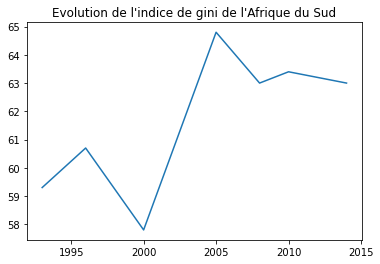

In [126]:
plt.plot(list(x), list(y))
plt.title("Evolution de l'indice de gini de l'Afrique du Sud")
plt.savefig("ig_AFR_Sud.png")

In [127]:
x2 = Gini_BRA["year_survey"].unique().dropna()
x3 = Gini_USA["year_survey"].unique().dropna()
x4 = Gini_ALB["year_survey"].unique().dropna()
x5 = Gini_SVN["year_survey"].unique().dropna()

In [128]:
y2 = Gini_BRA["gini_index"].to_numpy()
y3 = Gini_USA["gini_index"].to_numpy()
y4 = Gini_ALB["gini_index"].to_numpy()
y5 = Gini_SVN["gini_index"].to_numpy()


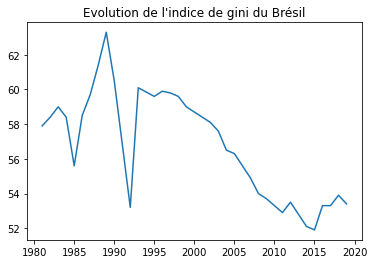

In [129]:
plt.plot(list(x2), list(y2))
plt.title("Evolution de l'indice de gini du Brésil")
plt.savefig("ig_bresil.png")

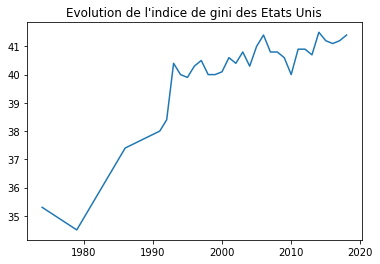

In [130]:
plt.plot(list(x3), list(y3),label='USA')
plt.title("Evolution de l'indice de gini des Etats Unis")
plt.savefig("ig_USA.png")

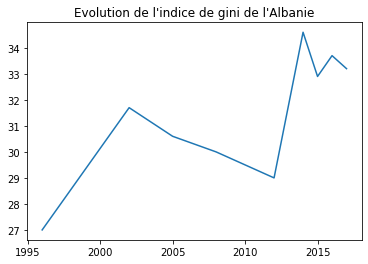

In [131]:
plt.plot(list(x4), list(y4),label='Albania')
plt.title("Evolution de l'indice de gini de l'Albanie")
plt.savefig("ig_ALB.png")

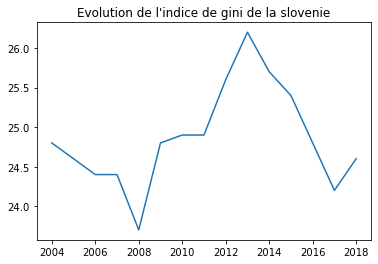

In [132]:
plt.plot(list(x5), list(y5),label='Slovenia')
plt.title("Evolution de l'indice de gini de la slovenie")
plt.savefig("ig_SLV.png")

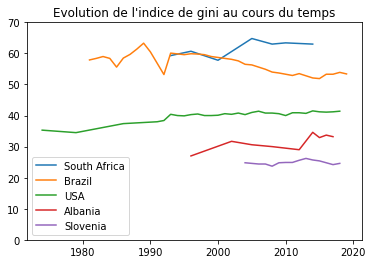

In [133]:
scale_factor = 70
ymin, ymax = plt.ylim()
plt.ylim(ymin * scale_factor, ymax * scale_factor)
plt.plot(list(x), list(y),label='South Africa')
plt.plot(list(x2), list(y2),label='Brazil')
plt.plot(list(x3), list(y3),label='USA')
plt.plot(list(x4), list(y4),label='Albania')
plt.plot(list(x5), list(y5),label='Slovenia')
plt.legend()
plt.title("Evolution de l'indice de gini au cours du temps")
plt.savefig("gini_index_evol_all")

###### Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

In [134]:
gini_mean = gini_gb.groupby("country")["gini_index"].mean().reset_index()
gini_mean

,country,gini_index
0,ABW,NaN
1,AFG,NaN
2,AGO,48.666667
3,ALB,31.411111
4,AND,NaN
...,...,...
212,XKX,29.016667
213,YEM,35.466667
214,ZAF,61.714286
215,ZMB,52.688889


In [135]:
gini_asc = gini_mean.sort_values(by="gini_index").reset_index(drop=True)
gini_asc.head(5)

,country,gini_index
0,SVN,24.866667
1,CZE,25.894737
2,SVK,26.492857
3,DNK,26.495000
4,FIN,26.795000


In [136]:
gini_desc = gini_mean.sort_values(by="gini_index",ascending=False).reset_index(drop=True)
gini_desc.head(5)

,country,gini_index
0,ZAF,61.714286
1,NAM,61.133333
2,CAF,58.750000
3,BWA,58.700000
4,SUR,57.900000


In [137]:
# position de la france
gini_asc.loc[gini_asc["country"]=="FRA"]

,country,gini_index
33,FRA,32.419048


### Mission 3
Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :

\(m_{j}\) le revenu moyen du pays  \(j\)

\(G_{j}\) l'indice de Gini du pays \(j\)

Il nous manque donc, pour un individu  \(i\) , la classe de revenu \(c_{i,parent}\) de ses parents.

Nous supposons ici que l'on associe à chaque individu \(i\) une unique classe \(c_{i,parent}\) ; quel que soit le nombre de parents de \(i\).

Nous allons donc simuler cette information grâce à un coefficient \(\rho_{j}\) (propre à chaque pays \(j\) ), mesurant une corrélation entre le revenu de l'individu \(i\) et le revenu de ses parents. Ce coefficient sera ici appelé coefficient d'élasticité ; il mesure la mobilité intergénérationnelle du revenu. Ce coefficient est déterminé par une régression linéaire simple dans laquelle le logarithme du revenu de l'enfant \(Y_{child}\) est une fonction du logarithme du revenu des parents \(Y_{parent}\) :

\[ln(Y_{child}) = \alpha + \rho_j\ ln(Y_{parent}) + \epsilon\]

In [138]:
#pip install pandarallel, 
#from pandarallel import pandarallel
#pandarallel.initialize(nb_workers=4)

In [139]:
data.head()

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income
0,0,ALB,2008,1,100,728.89795,7297.0,Albania,2947314,30.0,0.314624,6.591534
1,1,ALB,2008,2,100,916.66235,7297.0,Albania,2947314,30.0,0.314624,6.820739
2,2,ALB,2008,3,100,1010.91600,7297.0,Albania,2947314,30.0,0.314624,6.918612
3,3,ALB,2008,4,100,1086.90780,7297.0,Albania,2947314,30.0,0.314624,6.991092
4,4,ALB,2008,5,100,1132.69970,7297.0,Albania,2947314,30.0,0.314624,7.032359


##### Ajout du coeficient d 'élasticité'

In [140]:
rho = pd.read_csv('IGE_P7.csv')
rho.head()

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.1
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.1


In [141]:
rho.sort_values(by="IGEincome").head()


,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
1837,Finland,FIN,FIN,High income,High-income economies,High income,0,ESS,1960,Retrospective question,...,NaN,NaN,NaN,NaN,NaN,0.112876,NaN,NaN,NaN,NaN
1839,Finland,FIN,FIN,High income,High-income economies,High income,0,ESS,1960,Retrospective question,...,NaN,NaN,NaN,NaN,NaN,0.112876,NaN,NaN,NaN,NaN
1840,Finland,FIN,FIN,High income,High-income economies,High income,0,ESS,1960,Retrospective question,...,NaN,NaN,NaN,NaN,NaN,0.112876,NaN,NaN,NaN,NaN
1841,Finland,FIN,FIN,High income,High-income economies,High income,0,ESS,1960,Retrospective question,...,NaN,NaN,NaN,NaN,NaN,0.112876,NaN,NaN,NaN,NaN
1842,Finland,FIN,FIN,High income,High-income economies,High income,0,ESS,1960,Retrospective question,...,NaN,NaN,NaN,NaN,NaN,0.112876,NaN,NaN,NaN,NaN


In [142]:
rho_used = pd.DataFrame(rho, columns=["iso3","year","IGEincome", "incgroup4"])
rho_used.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6504 entries, 0 to 6503
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   iso3       6504 non-null   object 
 1   year       6504 non-null   int64  
 2   IGEincome  853 non-null    float64
 3   incgroup4  6504 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 203.4+ KB


In [143]:
rho_used = rho_used.rename(columns={"iso3":"country"})
rho_used = rho_used.rename(columns={"year":"year_survey"}) 
rho_used

,country,year_survey,IGEincome,incgroup4
0,AFG,1980,NaN,Low income
1,AFG,1980,NaN,Low income
2,AFG,1980,NaN,Low income
3,AFG,1980,NaN,Low income
4,AFG,1980,NaN,Low income
...,...,...,...,...
6499,ZMB,1980,NaN,Lower middle income
6500,ZMB,1980,NaN,Lower middle income
6501,ZMB,1980,NaN,Lower middle income
6502,ZMB,1980,NaN,Lower middle income


In [144]:
rho_used.year_survey.unique()

array([1980, 1940, 1950, 1960, 1970], dtype=int64)

In [145]:

rho_nan = rho_used[rho_used.IGEincome.isna()]
rho_nan

,country,year_survey,IGEincome,incgroup4
0,AFG,1980,NaN,Low income
1,AFG,1980,NaN,Low income
2,AFG,1980,NaN,Low income
3,AFG,1980,NaN,Low income
4,AFG,1980,NaN,Low income
...,...,...,...,...
6499,ZMB,1980,NaN,Lower middle income
6500,ZMB,1980,NaN,Lower middle income
6501,ZMB,1980,NaN,Lower middle income
6502,ZMB,1980,NaN,Lower middle income


In [146]:
# nous allons remplacer les nan par la moyenne des groupe de revenue auquel ils appartiennnt
rho.groupby(["incgroup4"])["IGEincome"].mean().reset_index().drop_duplicates()

,incgroup4,IGEincome
0,High income,0.348050
1,Low income,0.639089
2,Lower middle income,0.665950
3,Upper middle income,0.616741


In [147]:
rho_nan.incgroup4.unique()

array(['Low income', 'Upper middle income', 'Lower middle income',
       'High income'], dtype=object)

In [148]:
rho_na_Low_inc = rho_nan.loc[rho_nan["incgroup4"]=="Low income"]
rho_na_Low_inc = rho_na_Low_inc.fillna(value={"IGEincome": 0.639089})
rho_na_Low_inc

,country,year_survey,IGEincome,incgroup4
0,AFG,1980,0.639089,Low income
1,AFG,1980,0.639089,Low income
2,AFG,1980,0.639089,Low income
3,AFG,1980,0.639089,Low income
4,AFG,1980,0.639089,Low income
...,...,...,...,...
6487,COD,1980,0.639089,Low income
6488,COD,1980,0.639089,Low income
6489,COD,1980,0.639089,Low income
6490,COD,1980,0.639089,Low income


In [149]:
rho_na_Up_middl_inc = rho_nan.loc[rho_nan["incgroup4"]=="Upper middle income"]
rho_na_Up_middl_inc = rho_na_Up_middl_inc.fillna(value={"IGEincome": 0.616741})

rho_na_Low_middl_inc = rho_nan.loc[rho_nan["incgroup4"]=="Lower middle income"]
rho_na_Low_middl_inc=rho_na_Low_middl_inc.fillna(value={"IGEincome": 0.665950})

rho_na_High_inc = rho_nan.loc[rho_nan["incgroup4"]=="High income"]
rho_na_High_inc= rho_na_High_inc.fillna(value={"IGEincome": 0.348050})

In [150]:
rho_used = rho_used[~rho_used["IGEincome"].isin(["NaN"])]
rho_used

,country,year_survey,IGEincome,incgroup4
60,ALB,1970,0.815874,Upper middle income
61,ALB,1970,0.815874,Upper middle income
62,ALB,1970,0.815874,Upper middle income
63,ALB,1970,0.815874,Upper middle income
64,ALB,1970,0.815874,Upper middle income
...,...,...,...,...
6481,COD,1970,0.707703,Low income
6482,COD,1970,0.707703,Low income
6483,COD,1970,0.707703,Low income
6484,COD,1970,0.707703,Low income


In [151]:
rho_used= rho_used.append(rho_na_Low_inc)


In [152]:
rho_used= rho_used.append(rho_na_Up_middl_inc)
rho_used= rho_used.append(rho_na_Low_middl_inc)
rho_used= rho_used.append(rho_na_High_inc)


In [153]:
rho_used_1=rho_used.drop(columns="incgroup4")
rho_used_1.head()

,country,year_survey,IGEincome
60,ALB,1970,0.815874
61,ALB,1970,0.815874
62,ALB,1970,0.815874
63,ALB,1970,0.815874
64,ALB,1970,0.815874


In [154]:
rho_used = rho_used.drop(columns=["IGEincome","year_survey"])
rho_used = rho_used.drop_duplicates().reset_index(drop=True)
rho_used

,country,incgroup4
0,ALB,Upper middle income
1,AUS,High income
2,AUT,High income
3,BEL,High income
4,BEN,Low income
...,...,...
145,ISL,High income
146,ISR,High income
147,LTU,High income
148,POL,High income


In [155]:
rho_used_1 = rho_used_1.groupby("country").mean()["IGEincome"].reset_index()
rho_used_1

,country,IGEincome
0,AFG,0.639089
1,AGO,0.616741
2,ALB,0.656568
3,ARG,0.616741
4,ARM,0.665950
...,...,...
145,VNM,0.623848
146,VUT,0.665950
147,YEM,0.665950
148,ZAF,0.628793


In [156]:
rho_used=pd.merge(rho_used_1, rho_used, on="country", how = "left")
rho_used

,country,IGEincome,incgroup4
0,AFG,0.639089,Low income
1,AGO,0.616741,Upper middle income
2,ALB,0.656568,Upper middle income
3,ARG,0.616741,Upper middle income
4,ARM,0.665950,Lower middle income
...,...,...,...
145,VNM,0.623848,Lower middle income
146,VUT,0.665950,Lower middle income
147,YEM,0.665950,Lower middle income
148,ZAF,0.628793,Upper middle income


##### #Ajout du coeficient d'élasticité à notre base

In [157]:
data=pd.merge(data,rho_used, on="country", how = "left")
data

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income,IGEincome,incgroup4
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,0.314624,6.591534,0.656568,Upper middle income
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,0.314624,6.820739,0.656568,Upper middle income
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,0.314624,6.918612,0.656568,Upper middle income
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,0.314624,6.991092,0.656568,Upper middle income
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,0.314624,7.032359,0.656568,Upper middle income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.697803,0.652812,Low income
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.815402,0.652812,Low income
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.963954,0.652812,Low income
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,7.159761,0.652812,Low income


In [158]:
# donnée manquantes?
data_IGE_na = data[data.IGEincome.isna()]
data_IGE_na

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income,IGEincome,incgroup4
5800,5800,XKX,2008,1,100,437.89370,7249.4,Kosovo,1747383,NaN,0.324475,6.081976,NaN,NaN
5801,5801,XKX,2008,2,100,508.17133,7249.4,Kosovo,1747383,NaN,0.324475,6.230819,NaN,NaN
5802,5802,XKX,2008,3,100,591.82820,7249.4,Kosovo,1747383,NaN,0.324475,6.383216,NaN,NaN
5803,5803,XKX,2008,4,100,668.00000,7249.4,Kosovo,1747383,NaN,0.324475,6.504288,NaN,NaN
5804,5804,XKX,2008,5,100,730.40220,7249.4,Kosovo,1747383,NaN,0.324475,6.593595,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,SYR,2004,96,100,1702.83960,4512.0,Syrian Arab Republic,17827827,NaN,0.367612,7.440052,NaN,NaN
9996,9996,SYR,2004,97,100,1883.93970,4512.0,Syrian Arab Republic,17827827,NaN,0.367612,7.541120,NaN,NaN
9997,9997,SYR,2004,98,100,2157.02400,4512.0,Syrian Arab Republic,17827827,NaN,0.367612,7.676485,NaN,NaN
9998,9998,SYR,2004,99,100,2622.62130,4512.0,Syrian Arab Republic,17827827,NaN,0.367612,7.871930,NaN,NaN


il manque les données du kossovo et de la syrie
du document text sur l'elasticité,
kossovo situé en europe : elasticité=0.4
syrie situé en Asie : elasticité =0.5

    

In [159]:
data_IGE_XKX = data_IGE_na.loc[data_IGE_na["country"]=="XKX"]
data_IGE_XKX= data_IGE_XKX.fillna(value={"IGEincome": 0.4})
data_IGE_SYR= data_IGE_na.loc[data_IGE_na["country"]=="SYR"]
data_IGE_SYR= data_IGE_SYR.fillna(value={"IGEincome": 0.5})

In [160]:
data=data[~data["IGEincome"].isin(["NaN"])]
data= data.append(data_IGE_XKX,ignore_index=False)
data= data.append(data_IGE_SYR,ignore_index=False)
data[data.IGEincome.isna()]

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income,IGEincome,incgroup4


In [161]:
data = data.sort_values(by="index")
data 

,index,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income,IGEincome,incgroup4
0,0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,0.314624,6.591534,0.656568,Upper middle income
1,1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,0.314624,6.820739,0.656568,Upper middle income
2,2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,0.314624,6.918612,0.656568,Upper middle income
3,3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,0.314624,6.991092,0.656568,Upper middle income
4,4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,0.314624,7.032359,0.656568,Upper middle income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.697803,0.652812,Low income
11596,11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.815402,0.652812,Low income
11597,11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.963954,0.652812,Low income
11598,11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,7.159761,0.652812,Low income


In [162]:
data = data.drop(columns="index")
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income,IGEincome,incgroup4
0,ALB,2008,1,100,728.89795,7297.00000,Albania,2947314,30.0,0.314624,6.591534,0.656568,Upper middle income
1,ALB,2008,2,100,916.66235,7297.00000,Albania,2947314,30.0,0.314624,6.820739,0.656568,Upper middle income
2,ALB,2008,3,100,1010.91600,7297.00000,Albania,2947314,30.0,0.314624,6.918612,0.656568,Upper middle income
3,ALB,2008,4,100,1086.90780,7297.00000,Albania,2947314,30.0,0.314624,6.991092,0.656568,Upper middle income
4,ALB,2008,5,100,1132.69970,7297.00000,Albania,2947314,30.0,0.314624,7.032359,0.656568,Upper middle income
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,COD,2008,96,100,810.62330,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.697803,0.652812,Low income
11596,COD,2008,97,100,911.78340,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.815402,0.652812,Low income
11597,COD,2008,98,100,1057.80740,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,6.963954,0.652812,Low income
11598,COD,2008,99,100,1286.60290,303.19305,"Congo, Dem. Rep.",60411195,NaN,0.453997,7.159761,0.652812,Low income


In [163]:
data.to_csv("data_clean_P7.csv",  encoding= "iso-8859-1", index = False)

###### Mission3_suite
Pour chaque pays, nous allons utiliser une génération aléatoire de la classe de revenu des parents, à partir de ces seules deux informations : \(\rho_j\) et la classe de revenu de l'enfant  \(c_{i,child}\). Voici le protocole de génération pour un pays \(j\) donné, qui se base sur l'équation donnée ci dessus :

\[ln(Y_{child}) = \alpha + \rho_j\ ln(Y_{parent}) + \epsilon\]

In [164]:
import scipy.stats as st
import pandas as pd
import numpy as np
from collections import Counter

Générez un grand nombre \(n\) de réalisations d'une variable que nous appellerons  \(ln(Y_{parent})\) selon une loi normale. Le choix de la moyenne et de l'écart type n'auront pas d'incidence sur le résultat final. \(n\) doit être supérieur à 1000 fois le nombre de quantiles.

Pour une valeur donnée de \(\rho_j\) (par exemple 0.9), calculez \(y_{child} = e^{\alpha+\rho_jln(y_{parent})+\epsilon}\) . Le choix de \( \alpha\) n'a aucune incidence sur le résultat final et peut être supprimé. À ce stade, \(y_{child}\) contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.

In [165]:
pj = 0.5                 # coefficient d'élasticité du pays j
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

In [166]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon (n realisation)
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
y_child, y_parents = generate_incomes(n, pj)

Pour chacun des \(n\) individus générés, calculez la classe de revenu  \(c_{i,child}\) ainsi que la classe de revenu de ses parents \(c_{i,parent}\) , à partir de \(y_{child}\) et \(y_{parent}\).

In [167]:
nb_quantiles = 100  # nombre de quantiles (nombre de classes de revenu)
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample


,y_child,y_parents,c_i_child,c_i_parent
0,0.125548,1.009288,4,51
1,1.889372,1.555366,72,68
2,0.338365,0.470875,17,23
3,3.100893,1.184855,85,58
4,0.994461,1.183810,50,58
...,...,...,...,...
99995,0.213761,0.611284,9,32
99996,3.331519,1.445894,86,65
99997,1.613707,1.446072,67,65
99998,0.820996,1.882647,44,74


À partir de cette dernière information, estimez pour chaque  \(c_{i,child}\) la distribution conditionnelle de \(c_{i,parent}\) . Par exemple, si vous observez 6 individus ayant à la fois  \(c_{i,child} = 5\) et \(c_{i,parent} = 8\) , et que 200 individus sur 20000 ont \( c_{i,child} = 5\) , alors la probabilité d'avoir \( c_{i,parent} = 8\) sachant  \(c_{i,child} = 5\) et sachant \(\rho_j=0.9\) sera estimée à 6/200 (On note cette probabilité comme ceci : \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\)). Si votre population est divisée en \(c\) classes de revenu, vous devriez alors avoir \(c^2\) estimations de ces probabilités conditionnelles, pour chaque pays.

In [168]:
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 
cd = conditional_distributions(sample, nb_quantiles)
cd1 = pd.DataFrame(cd)
cd1
cd1["country"] = "SYR"

In [169]:
cd1.head(10)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,country
0,0.107,0.060,0.061,0.042,0.033,0.046,0.032,0.038,0.025,0.030,...,0.000,0.001,0.001,0.000,0.001,0.000,0.000,0.000,0.000,SYR
1,0.062,0.052,0.025,0.049,0.034,0.032,0.035,0.022,0.025,0.032,...,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.003,0.001,SYR
2,0.053,0.045,0.032,0.034,0.032,0.029,0.028,0.025,0.018,0.022,...,0.004,0.002,0.001,0.000,0.001,0.001,0.000,0.000,0.000,SYR
3,0.054,0.037,0.026,0.045,0.028,0.034,0.023,0.019,0.019,0.029,...,0.001,0.000,0.001,0.002,0.000,0.001,0.001,0.002,0.001,SYR
4,0.035,0.038,0.028,0.026,0.037,0.024,0.030,0.022,0.025,0.029,...,0.001,0.002,0.001,0.002,0.001,0.001,0.001,0.000,0.000,SYR
5,0.035,0.032,0.028,0.027,0.021,0.027,0.024,0.023,0.018,0.026,...,0.000,0.004,0.002,0.005,0.000,0.000,0.001,0.000,0.000,SYR
6,0.039,0.025,0.026,0.017,0.024,0.020,0.024,0.020,0.026,0.023,...,0.002,0.001,0.001,0.000,0.000,0.003,0.000,0.000,0.000,SYR
7,0.042,0.035,0.025,0.023,0.023,0.024,0.020,0.017,0.022,0.028,...,0.004,0.002,0.003,0.003,0.002,0.001,0.001,0.001,0.001,SYR
8,0.035,0.027,0.022,0.018,0.018,0.016,0.021,0.021,0.020,0.010,...,0.006,0.003,0.001,0.003,0.004,0.001,0.000,0.002,0.001,SYR
9,0.023,0.023,0.019,0.028,0.027,0.019,0.024,0.012,0.013,0.023,...,0.002,0.002,0.003,0.002,0.003,0.001,0.004,0.000,0.001,SYR


In [170]:
# pour verifier le fonctionnement de append
cd1.append(cd1, ignore_index=True).shape

(200, 101)

In [171]:
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

In [172]:
c_i_child = 3
c_i_parent = 5
p = proba_cond(c_i_parent, c_i_child, cd)
p

0.034

In [173]:

print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))



P(c_i_parent = 5 | c_i_child = 3, pj = 0.5) = 0.034


Optionnellement et pour vérifier la cohérence de votre code, vous pouvez créer un graphique représentant ces distributions conditionnelles. 

In [174]:
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
# La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
#plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10


In [175]:
def hamilton_allocation(ratios, k):
    frac, results = np.modf(k * ratios)
    remainder = int(k - results.sum())
    
    indices = np.argsort(frac)[::-1]
    results[indices[0:remainder]] += 1
 
    return results.astype(int)

##### methode de hamilton pour eviter les décimals (avoir des bon arrondis dont la somme totale correspond à au montant de depart)
lien wiki pour comprendre la methode
http://mlwiki.org/index.php/Hamilton%27s_Method

In [176]:
#distribution condiationnel pour un quantile =1 . on a 100 distribution normalement. la somme de proba dois faire 500
cd[0]

array([0.107, 0.06 , 0.061, 0.042, 0.033, 0.046, 0.032, 0.038, 0.025,
       0.03 , 0.022, 0.021, 0.029, 0.025, 0.008, 0.016, 0.019, 0.012,
       0.009, 0.018, 0.01 , 0.014, 0.012, 0.012, 0.011, 0.013, 0.012,
       0.006, 0.012, 0.006, 0.006, 0.015, 0.008, 0.009, 0.006, 0.005,
       0.005, 0.003, 0.01 , 0.003, 0.006, 0.012, 0.011, 0.008, 0.009,
       0.006, 0.007, 0.004, 0.003, 0.005, 0.005, 0.007, 0.004, 0.003,
       0.006, 0.006, 0.006, 0.002, 0.   , 0.001, 0.003, 0.002, 0.007,
       0.005, 0.002, 0.   , 0.001, 0.001, 0.003, 0.002, 0.002, 0.001,
       0.004, 0.   , 0.001, 0.002, 0.003, 0.001, 0.003, 0.001, 0.003,
       0.001, 0.   , 0.   , 0.003, 0.   , 0.002, 0.001, 0.   , 0.001,
       0.   , 0.   , 0.001, 0.001, 0.   , 0.001, 0.   , 0.   , 0.   ,
       0.   ])

In [177]:
cd[0].sum()

1.0000000000000002

In [178]:
# je veux multiplier chaque proba par 500 et que le calcul me donne une valeur non decimal de sorte que si je fais
#la somme totale, j'obtienne 500
p_array= cd1[0]
ham=hamilton_allocation(p_array,500)
ham

0     53
1     31
2     26
3     27
4     17
      ..
95     0
96     0
97     0
98     0
99     0
Name: 0, Length: 100, dtype: int32

In [179]:
ham.sum()

500

In [180]:
# essai pour les 100 quantile
hamilton=pd.DataFrame()
for m in range(100):
    p_array= cd1[m]
    ham=hamilton_allocation(p_array,500)
    hamilton = hamilton.append(ham)



In [181]:
hamilton


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,53.0,31.0,26.0,27.0,17.0,17.0,19.0,21.0,17.0,11.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30.0,26.0,22.0,18.0,19.0,16.0,12.0,17.0,13.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,31.0,12.0,16.0,13.0,14.0,14.0,13.0,12.0,11.0,9.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21.0,24.0,17.0,22.0,13.0,13.0,8.0,11.0,9.0,14.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,16.0,17.0,16.0,14.0,18.0,10.0,12.0,11.0,9.0,13.0,...,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,...,13.0,8.0,19.0,11.0,16.0,15.0,10.0,15.0,17.0,23.0
96,0.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,...,10.0,11.0,13.0,12.0,10.0,16.0,12.0,17.0,17.0,26.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,11.0,15.0,12.0,12.0,13.0,15.0,19.0,19.0,26.0,26.0
98,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,14.0,10.0,13.0,14.0,13.0,16.0,20.0,15.0,26.0,31.0


In [182]:
sum1= hamilton.sum()
sum1.sum()

50000.0

#### Pour tous les pays

In [183]:
data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Country Name,population,gini_index_WB,gini_index,log_income,IGEincome,incgroup4
0,ALB,2008,1,100,728.89795,7297.0,Albania,2947314,30.0,0.314624,6.591534,0.656568,Upper middle income
1,ALB,2008,2,100,916.66235,7297.0,Albania,2947314,30.0,0.314624,6.820739,0.656568,Upper middle income
2,ALB,2008,3,100,1010.91600,7297.0,Albania,2947314,30.0,0.314624,6.918612,0.656568,Upper middle income
3,ALB,2008,4,100,1086.90780,7297.0,Albania,2947314,30.0,0.314624,6.991092,0.656568,Upper middle income
4,ALB,2008,5,100,1132.69970,7297.0,Albania,2947314,30.0,0.314624,7.032359,0.656568,Upper middle income


In [184]:
country = list(data['country'].unique())
len(country)

116

In [185]:
data5 = data.drop(columns=["income", "quantile","log_income"])
data5 = data5.drop_duplicates()
data5

,country,year_survey,nb_quantiles,gdpppp,Country Name,population,gini_index_WB,gini_index,IGEincome,incgroup4
0,ALB,2008,100,7297.00000,Albania,2947314,30.0,0.314624,0.656568,Upper middle income
100,ARG,2008,100,13220.00000,Argentina,40080159,44.9,0.459902,0.616741,Upper middle income
200,ARM,2008,100,5611.00000,Armenia,2907615,29.2,0.273108,0.665950,Lower middle income
300,AUT,2008,100,36193.00000,Austria,8321496,30.4,0.288279,0.327493,High income
400,AZE,2008,100,8101.00000,Azerbaijan,8763400,NaN,0.322321,0.616741,Upper middle income
...,...,...,...,...,...,...,...,...,...,...
11100,VNM,2006,100,2578.00000,Vietnam,84617545,35.8,0.387481,0.623848,Lower middle income
11200,PSE,2009,100,3708.70000,West Bank and Gaza,3689099,34.5,0.365068,0.665950,Lower middle income
11300,YEM,2008,100,2224.00000,"Yemen, Rep.",21892149,NaN,0.384161,0.665950,Lower middle income
11400,ZAF,2008,100,9602.00000,South Africa,49779472,63.0,0.679779,0.628793,Upper middle income


In [186]:
len(data5.IGEincome.values)
   

116

In [187]:
Pj = list(data5.IGEincome.values) 


In [188]:
len(data5.IGEincome.values)

116

##### les proba conditionnelle pour tous les pays :  ****programme très long, le dataframe obtenue a été enregistré en fichier csv

nb_quantiles = 100
N = 100*1000
cdFINAL = pd.DataFrame()
k = 0
for j in country:
    i=Pj[k]
    y_child, y_parents = generate_incomes(N, i) # appelle la fonction generate_incomes() defini plus haut
    sample = compute_quantiles(y_child, y_parents, nb_quantiles) # appelle la fonction compute_quantiles() defini plus haut
    cd = conditional_distributions(sample, nb_quantiles) # appelle la fonction conditional_distributions() defini plus haut
    cd1 = pd.DataFrame(cd)   
    cd1["country"] = j
    cd1["Pj"]=i
    cdFINAL=cdFINAL.append(cd1)
    k=k+1
    cdFINAL

In [189]:
# Prob = cdFINAL.reset_index()
# Prob["quantile"] = Prob["index"] +1
#Prob

In [190]:
# recuperation de la matrice dans un fichier csv pour eviter le temps d'exécution la prochaine fois
#Prob.to_csv("Prob.csv",  encoding= "iso-8859-1", index = False)

In [191]:
Prob_cond = pd.read_csv('Prob.csv') 
Prob_cond

,index,0,1,2,3,4,5,6,7,8,...,93,94,95,96,97,98,99,country,Pj,quantile
0,0,0.162,0.086,0.072,0.060,0.039,0.048,0.039,0.032,0.035,...,0.000,0.000,0.000,0.001,0.000,0.000,0.000,ALB,0.656568,1
1,1,0.083,0.071,0.050,0.059,0.045,0.038,0.025,0.032,0.026,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ALB,0.656568,2
2,2,0.069,0.057,0.057,0.056,0.033,0.043,0.028,0.030,0.027,...,0.001,0.000,0.001,0.000,0.000,0.000,0.000,ALB,0.656568,3
3,3,0.047,0.040,0.027,0.034,0.033,0.036,0.031,0.042,0.025,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ALB,0.656568,4
4,4,0.052,0.041,0.031,0.043,0.028,0.028,0.031,0.030,0.026,...,0.000,0.000,0.001,0.000,0.000,0.000,0.000,ALB,0.656568,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,95,0.000,0.000,0.000,0.002,0.001,0.000,0.000,0.002,0.000,...,0.025,0.028,0.033,0.045,0.038,0.043,0.058,COD,0.652812,96
11596,96,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.004,0.002,...,0.026,0.036,0.031,0.037,0.036,0.042,0.054,COD,0.652812,97
11597,97,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,...,0.044,0.034,0.037,0.055,0.046,0.038,0.055,COD,0.652812,98
11598,98,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.001,...,0.028,0.026,0.036,0.054,0.040,0.059,0.099,COD,0.652812,99


In [192]:
Prob_cond2 =Prob_cond.drop(columns=["Pj","country","quantile"])
Prob_cond2 = Prob_cond2.rename(columns={"index":"quantile_0"})

In [193]:
Prob_cond2 

,quantile_0,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,0.162,0.086,0.072,0.060,0.039,0.048,0.039,0.032,0.035,...,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000
1,1,0.083,0.071,0.050,0.059,0.045,0.038,0.025,0.032,0.026,...,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2,0.069,0.057,0.057,0.056,0.033,0.043,0.028,0.030,0.027,...,0.000,0.001,0.002,0.001,0.000,0.001,0.000,0.000,0.000,0.000
3,3,0.047,0.040,0.027,0.034,0.033,0.036,0.031,0.042,0.025,...,0.000,0.002,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,4,0.052,0.041,0.031,0.043,0.028,0.028,0.031,0.030,0.026,...,0.002,0.000,0.001,0.000,0.000,0.001,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,95,0.000,0.000,0.000,0.002,0.001,0.000,0.000,0.002,0.000,...,0.026,0.028,0.024,0.025,0.028,0.033,0.045,0.038,0.043,0.058
11596,96,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.004,0.002,...,0.029,0.026,0.032,0.026,0.036,0.031,0.037,0.036,0.042,0.054
11597,97,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,...,0.025,0.024,0.030,0.044,0.034,0.037,0.055,0.046,0.038,0.055
11598,98,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.001,...,0.038,0.029,0.036,0.028,0.026,0.036,0.054,0.040,0.059,0.099


##### 8. Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution.

In [194]:
data_nvo = pd.DataFrame(data, columns = ["year_survey","Country Name","country","population","gdpppp","incgroup4","gini_index","income","log_income","nb_quantiles","quantile","IGEincome"])
data_nvo = data_nvo.rename(columns={"IGEincome": "Pj"})
data_nvo.head()

,year_survey,Country Name,country,population,gdpppp,incgroup4,gini_index,income,log_income,nb_quantiles,quantile,Pj
0,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568
1,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,916.66235,6.820739,100,2,0.656568
2,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,1010.91600,6.918612,100,3,0.656568
3,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,1086.90780,6.991092,100,4,0.656568
4,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,1132.69970,7.032359,100,5,0.656568


In [195]:
data_nvo

,year_survey,Country Name,country,population,gdpppp,incgroup4,gini_index,income,log_income,nb_quantiles,quantile,Pj
0,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568
1,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,916.66235,6.820739,100,2,0.656568
2,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,1010.91600,6.918612,100,3,0.656568
3,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,1086.90780,6.991092,100,4,0.656568
4,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,1132.69970,7.032359,100,5,0.656568
...,...,...,...,...,...,...,...,...,...,...,...,...
11595,2008,"Congo, Dem. Rep.",COD,60411195,303.19305,Low income,0.453997,810.62330,6.697803,100,96,0.652812
11596,2008,"Congo, Dem. Rep.",COD,60411195,303.19305,Low income,0.453997,911.78340,6.815402,100,97,0.652812
11597,2008,"Congo, Dem. Rep.",COD,60411195,303.19305,Low income,0.453997,1057.80740,6.963954,100,98,0.652812
11598,2008,"Congo, Dem. Rep.",COD,60411195,303.19305,Low income,0.453997,1286.60290,7.159761,100,99,0.652812


In [196]:
data_500 = pd.concat([data_nvo]*500, ignore_index=True)
data_500

,year_survey,Country Name,country,population,gdpppp,incgroup4,gini_index,income,log_income,nb_quantiles,quantile,Pj
0,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568
1,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,916.66235,6.820739,100,2,0.656568
2,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,1010.91600,6.918612,100,3,0.656568
3,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,1086.90780,6.991092,100,4,0.656568
4,2008,Albania,ALB,2947314,7297.00000,Upper middle income,0.314624,1132.69970,7.032359,100,5,0.656568
...,...,...,...,...,...,...,...,...,...,...,...,...
5799995,2008,"Congo, Dem. Rep.",COD,60411195,303.19305,Low income,0.453997,810.62330,6.697803,100,96,0.652812
5799996,2008,"Congo, Dem. Rep.",COD,60411195,303.19305,Low income,0.453997,911.78340,6.815402,100,97,0.652812
5799997,2008,"Congo, Dem. Rep.",COD,60411195,303.19305,Low income,0.453997,1057.80740,6.963954,100,98,0.652812
5799998,2008,"Congo, Dem. Rep.",COD,60411195,303.19305,Low income,0.453997,1286.60290,7.159761,100,99,0.652812


###### ou encore ce code plus long mais qui permet de garder l'ordre
data500 = pd.DataFrame()
for j in country:
    Qpa500 = pd.DataFrame()
    for q in range(1,101): # quantiles allant de 1 à 100
        Qp= data.loc[(data["quantile"]==q) & (data['country'] == j)]
        Qp500 = pd.concat([Qp]*500, ignore_index=True)
        Qpa500 = Qpa500.append(Qp500)
    data500 = data500.append(Qpa500)
data500
    

##### 9. Pour chaque \(c_{i,child}\) et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes \( c_{i,parent}\) conformément aux distributions trouvées précédemment. Par exemple, si \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\) , alors vous assignerez la classe \(c_{i,parent} = 8\) à 15 des 500 individus du pays \( j\) ayant \(c_{i,child}=5\) , car 500*0.03 = 15.

###### essaie avec un seul pays: cça marche
nb_quantiles = 100
N = 100*1000
qu_parent = pd.DataFrame()
for j in range(1):
    i=Pj[0]
    y_child, y_parents = generate_incomes(N, i) # appelle la fonction generate_incomes() defini plus haut
    sample = compute_quantiles(y_child, y_parents, nb_quantiles) # appelle la fonction compute_quantiles() defini plus haut
    cd = conditional_distributions(sample, nb_quantiles) # appelle la fonction conditional_distributions() defini plus haut
    cd1 = pd.DataFrame(cd)
    Q_parent = pd.DataFrame()
    for q in range(100):
        p_array= cd1[q]
        nb_ligne=hamilton_allocation(p_array,500)
        Q_p=pd.DataFrame()
        for n in range(100):
            c_parent=[]
            for r in range(nb_ligne[n]):
                c_parent.append(n)
            Q = pd.DataFrame(c_parent, columns =["quantile_P"])
            Q_p = Q_p.append(Q)
            Q_p["country"] = j
            Q_p["Pj"] = i
            Q_p["quantile"] = q
        Q_parent = Q_parent.append(Q_p)
    qu_parent =qu_parent.append(Q_parent)

In [197]:
# qu_parent.head(501)

##### Programme pour tous les pays :  programme très long, le dataframe obtenue a été enregistré en fichier csv

nb_quantiles = 100
N = 100*1000
k=0
qu_parent = pd.DataFrame()
for j in country:
    i=Pj[k]
    y_child, y_parents = generate_incomes(N, i) # appelle la fonction generate_incomes() defini plus haut
    sample = compute_quantiles(y_child, y_parents, nb_quantiles) # appelle la fonction compute_quantiles() defini plus haut
    cd = conditional_distributions(sample, nb_quantiles) # appelle la fonction conditional_distributions() defini plus haut
    cd1 = pd.DataFrame(cd)
    Q_parent = pd.DataFrame()
    for q in range(100): # le nombre de quantile
        p_array= cd1[q]
        nb_ligne=hamilton_allocation(p_array,500) # methode de hamilton pour eviter les décimals
        Q_p=pd.DataFrame()
        for n in range(100): #le nombre de quantile
            c_parent=[]
            for r in range(nb_ligne[n]):
                c_parent.append(n)
            Q = pd.DataFrame(c_parent, columns =["quantile_P"])
            Q_p = Q_p.append(Q)
            Q_p["country"] = j
            Q_p["Pj"] = i
            Q_p["quantile"] = q
        Q_parent = Q_parent.append(Q_p)
    k=k+1
    qu_parent =qu_parent.append(Q_parent)

qu_parent

In [198]:
# recuperation de la matrice dans un fichier csv pour eviter le temps d'exécution la prochaine fois
#qu_parent.to_csv("qu_parent.csv",  encoding= "iso-8859-1", index = False)


In [199]:
Quantile_Parent = pd.read_csv('qu_parent.csv')
Quantile_Parent

,quantile_P,country,Pj,quantile
0,0,ALB,0.656568,0
1,0,ALB,0.656568,0
2,0,ALB,0.656568,0
3,0,ALB,0.656568,0
4,0,ALB,0.656568,0
...,...,...,...,...
5799995,99,COD,0.652812,99
5799996,99,COD,0.652812,99
5799997,99,COD,0.652812,99
5799998,99,COD,0.652812,99


In [200]:
Quantile_Parent["quantile_Parent"] = Quantile_Parent["quantile_P"]+1
Quantile_Parent["quantile_Enfant"] = Quantile_Parent["quantile"]+1
Quantile_Parent

,quantile_P,country,Pj,quantile,quantile_Parent,quantile_Enfant
0,0,ALB,0.656568,0,1,1
1,0,ALB,0.656568,0,1,1
2,0,ALB,0.656568,0,1,1
3,0,ALB,0.656568,0,1,1
4,0,ALB,0.656568,0,1,1
...,...,...,...,...,...,...
5799995,99,COD,0.652812,99,100,100
5799996,99,COD,0.652812,99,100,100
5799997,99,COD,0.652812,99,100,100
5799998,99,COD,0.652812,99,100,100


In [201]:
Quantile_Parent = Quantile_Parent.drop(columns=["quantile","quantile_P"])
Quantile_Parent

,country,Pj,quantile_Parent,quantile_Enfant
0,ALB,0.656568,1,1
1,ALB,0.656568,1,1
2,ALB,0.656568,1,1
3,ALB,0.656568,1,1
4,ALB,0.656568,1,1
...,...,...,...,...
5799995,COD,0.652812,100,100
5799996,COD,0.652812,100,100
5799997,COD,0.652812,100,100
5799998,COD,0.652812,100,100


In [202]:
Quantile_Parent = Quantile_Parent.rename(columns={"quantile_Enfant":"quantile"})
Quantile_Parent

,country,Pj,quantile_Parent,quantile
0,ALB,0.656568,1,1
1,ALB,0.656568,1,1
2,ALB,0.656568,1,1
3,ALB,0.656568,1,1
4,ALB,0.656568,1,1
...,...,...,...,...
5799995,COD,0.652812,100,100
5799996,COD,0.652812,100,100
5799997,COD,0.652812,100,100
5799998,COD,0.652812,100,100


In [203]:
# recuperation du tableau dans un fichier csv pour eviter le temps d'exécution la prochaine fois
# Quantile_Parent.to_csv("Quantile_Parent.csv",  encoding= "iso-8859-1", index = False)
Quantile_Par = pd.read_csv('Quantile_Parent.csv')
Quantile_Par


,country,Pj,quantile_Parent,quantile
0,ALB,0.656568,1,1
1,ALB,0.656568,1,1
2,ALB,0.656568,1,1
3,ALB,0.656568,1,1
4,ALB,0.656568,1,1
...,...,...,...,...
5799995,COD,0.652812,100,100
5799996,COD,0.652812,100,100
5799997,COD,0.652812,100,100
5799998,COD,0.652812,100,100


In [204]:
Quantile_Par["quantile"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [205]:
data_500_Sort = data_500.sort_values(by=["country","quantile"]).reset_index(drop=True)
data_500_Sort.head()

,year_survey,Country Name,country,population,gdpppp,incgroup4,gini_index,income,log_income,nb_quantiles,quantile,Pj
0,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568
1,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568
2,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568
3,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568
4,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568


In [206]:
Quantile_Par_sort = Quantile_Par.sort_values(by=["country","quantile"]).reset_index(drop=True)
Quantile_Par_sort

,country,Pj,quantile_Parent,quantile
0,ALB,0.656568,1,1
1,ALB,0.656568,1,1
2,ALB,0.656568,1,1
3,ALB,0.656568,1,1
4,ALB,0.656568,1,1
...,...,...,...,...
5799995,ZAF,0.628793,100,100
5799996,ZAF,0.628793,100,100
5799997,ZAF,0.628793,100,100
5799998,ZAF,0.628793,100,100


In [207]:
Quantile_Par.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5800000 entries, 0 to 5799999
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   country          object 
 1   Pj               float64
 2   quantile_Parent  int64  
 3   quantile         int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 177.0+ MB


In [208]:
data_500_Sort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5800000 entries, 0 to 5799999
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   year_survey   int64  
 1   Country Name  object 
 2   country       object 
 3   population    Int64  
 4   gdpppp        float64
 5   incgroup4     object 
 6   gini_index    float64
 7   income        float64
 8   log_income    float64
 9   nb_quantiles  int64  
 10  quantile      int64  
 11  Pj            float64
dtypes: Int64(1), float64(5), int64(3), object(3)
memory usage: 536.5+ MB


In [209]:
Quantile_Par.shape

(5800000, 4)

In [210]:
data_500_Sort.shape

(5800000, 12)

In [211]:
#data_fin = pd.merge(data_500_Sort, Quantile_Par_sort, on=["country", "Pj","quantile"])
#data_fin

In [212]:
data_500_Sort["quantile_P"] = Quantile_Par_sort["quantile_Parent"]
data_500_Sort.head(502)

,year_survey,Country Name,country,population,gdpppp,incgroup4,gini_index,income,log_income,nb_quantiles,quantile,Pj,quantile_P
0,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568,1
1,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568,1
2,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568,1
3,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568,1
4,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568,72
498,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568,73
499,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,100,1,0.656568,76
500,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,916.66235,6.820739,100,2,0.656568,1


##### 10 . 
Éventuellement et pour éviter toute confusion, effacez la variable \(c_{i,child}\)  : nous n'en avons pas besoin pour la mission 4.
##### 11.
Assurez-vous que votre nouvel échantillon contiennent bien les variables initialement présentes dans la World Income Distribution : \(m_j\) et \(G_j\) .

In [213]:
data_final_P7 = data_500_Sort.copy()


In [214]:
data_final_P7 = data_final_P7.drop(columns=["quantile","nb_quantiles"])

In [215]:
data_final_P7.head()

,year_survey,Country Name,country,population,gdpppp,incgroup4,gini_index,income,log_income,Pj,quantile_P
0,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1
1,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1
2,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1
3,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1
4,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1


Utilisez ce nouvel échantillon pour la mission 4.

In [216]:
# recuperation du tableau dans un fichier csv pour eviter le temps d'exécution la prochaine fois
#data_final_P7.to_csv("data_final_P7.csv",  encoding= "iso-8859-1", index = False)


## Mission 4
Pour cette mission 4, nous chercherons à expliquer le revenu des individus en fonction de plusieurs variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des parents, etc.

In [217]:
data_final = pd.read_csv('data_final_P7.csv')
data_final.head()

,year_survey,Country Name,country,population,gdpppp,incgroup4,gini_index,income,log_income,Pj,quantile_P
0,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1
1,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1
2,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1
3,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1
4,2008,Albania,ALB,2947314,7297.0,Upper middle income,0.314624,728.89795,6.591534,0.656568,1


###### Appliquez une ANOVA sur vos données, en n’incluant comme variable explicative que le pays de l’individu. Analysez la performance du modèle.

In [218]:
data_final["log_gdpppp"] = np.log(data_final["gdpppp"])
data_final = data_final.drop(columns=["population","year_survey","Country Name"])

In [219]:
data_final = data_final.drop(columns=["Pj"])
data_final

,country,gdpppp,incgroup4,gini_index,income,log_income,quantile_P,log_gdpppp
0,ALB,7297.0,Upper middle income,0.314624,728.89795,6.591534,1,8.895219
1,ALB,7297.0,Upper middle income,0.314624,728.89795,6.591534,1,8.895219
2,ALB,7297.0,Upper middle income,0.314624,728.89795,6.591534,1,8.895219
3,ALB,7297.0,Upper middle income,0.314624,728.89795,6.591534,1,8.895219
4,ALB,7297.0,Upper middle income,0.314624,728.89795,6.591534,1,8.895219
...,...,...,...,...,...,...,...,...
5799995,ZAF,9602.0,Upper middle income,0.679779,82408.55000,11.319444,100,9.169727
5799996,ZAF,9602.0,Upper middle income,0.679779,82408.55000,11.319444,100,9.169727
5799997,ZAF,9602.0,Upper middle income,0.679779,82408.55000,11.319444,100,9.169727
5799998,ZAF,9602.0,Upper middle income,0.679779,82408.55000,11.319444,100,9.169727


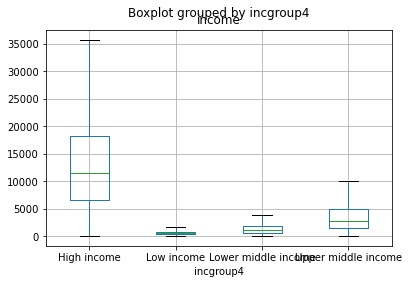

In [220]:
data_final.boxplot(column = "income", by= "incgroup4", showfliers= False )
plt.savefig('rev_pays')

In [221]:
data_finale = data_final.drop(columns=["incgroup4"])

In [222]:

import statsmodels.formula.api 
import statsmodels.api

In [ ]:
# Si  η2Y/X=0  , cela signifie que les moyennes par classes sont toutes égales. Il n’y a donc pas à priori de relation entre les variables Y et X. Au contraire, si η2Y/X=1 , cela signifie que les moyennes par classes sont très différentes, chacune des classes étant constituée de valeurs identiques : il existe donc à priori une relation entre les variables Y et X.
# on a eta_squared = 0,5 . ce qui laisse penser qu'il y a effectivement une corrélation entre le revenu des individus et leur pays

In [ ]:
# fit = statsmodels.formula.api.ols('income ~ country', data = data_final).fit()

l'ordinateur est incapable d'exécuter 5,8 millions de data. Nous allons donc prendre un chantillon et continuer la suite avec cet echantillon

In [223]:
# echantillon de 60% des données d'origine
data_finale = data_finale.sample(frac = 0.6)

In [224]:
data_finale.shape

(3480000, 7)

In [225]:
fit = statsmodels.formula.api.ols('income ~ country', data = data_finale).fit()


In [228]:
# statsmodels.api.stats.anova_lm(fit, robust = 'hc3') : utilise une correction pour l'hétéroscédasticité 
aov_table = statsmodels.api.stats.anova_lm(fit, robust = 'hc3')
aov_table 

,df,sum_sq,mean_sq,F,PR(>F)
country,115.0,1.528362e+14,1.329010e+12,29989.445734,0.0
Residual,3479884.0,1.542143e+14,4.431593e+07,NaN,NaN


L'hypothèse nulle veut que les moyennes de population soient toutes égales.
la p_value est inferieur à 1%. alors les differences entre certaines moyennes sont statistiquement significatives.

le eta_squared permet de mesurer l'effet taille. Il mesure la proportion de la variance associée à chaque effet principal et effet d'interaction mais il  est quelque peu biaisé car il est basé uniquement sur les sommes des carrés de l'échantillon.
le omega_squared est une mesure moins biaisée de la taille de l'effet. 

la p_value peut seulement nous dire s'il existe ou non une association significative entre deux variables, mais une mesure de l'ampleur de l'effet, comme Eta au carré, peut nous indiquer la force de l'association entre les variables.

In [229]:
#Nous allons calculler le eta square et le omega square et l'ajouter à notre tableau


def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
country,1.528362e+14,115.0,1.329010e+12,29989.445734,0.0,0.497756,0.497739
Residual,1.542143e+14,3479884.0,4.431593e+07,NaN,NaN,NaN,NaN


l'effet taille ici est de 0.49 . il est tres elevé.

##### Appliquez une régression linéaire sur vos données, en incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu. Quel est le pourcentage de variance expliquée par votre modèle ?

In [ ]:
# echantillon de 60% des données d'origine
data_finale 

In [ ]:
# Methoode avec statsmodels

In [230]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [232]:
# list des variables explicative
feature_cols =["gdpppp","gini_index"]

X=data_finale[feature_cols]

# variable dépendante
y = data_finale["income"]

In [233]:
x = sm.add_constant(X)
lr = sm.OLS(endog=y,exog=x)
res = lr.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                 1.174e+05
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:33:16   Log-Likelihood:            -3.6658e+07
No. Observations:             3480000   AIC:                         7.332e+07
Df Residuals:                 3479997   BIC:                         7.332e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.634e+04     21.756    750.891      0.0

In [ ]:
res.params

Selon ce modèle, donnez la décomposition de variance totale expliquée par : le pays de naissance (ie. le revenu moyen et l’indice de Gini) ;
les autres facteurs non considérés dans le modèle (efforts, chance, etc.).

In [234]:
# la variance totale
res.centered_tss 

307050486787249.56

In [235]:
#  la variance expliquée (somme des carrés des différences entre valeurs prédites et moyenne)
res.ess

19410836178635.5

In [236]:
#la variance résiduelle (somme des carrés des résidus). centered_tss = ess + ssr.
res.ssr

287639650608614.06

In [237]:
res.ess/res.centered_tss 

0.06321708322867751

In [238]:
# REGRESSION AVEC LE LOG
# list des variables explicative
feature_cols =["log_gdpppp","gini_index"]

X=data_finale[feature_cols]

# variable dépendante
y = data_finale["log_income"]

x = sm.add_constant(X)
lr = sm.OLS(endog=y,exog=x)
res = lr.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                 1.925e+06
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:33:44   Log-Likelihood:            -4.7650e+06
No. Observations:             3480000   AIC:                         9.530e+06
Df Residuals:                 3479997   BIC:                         9.530e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8615      0.005    627.452      0.0

In [239]:
# la variance totale
res.centered_tss 

6637356.538675126

In [240]:
#  la variance expliquée (somme des carrés des différences entre valeurs prédites et moyenne)
res.ess

3486577.2299631964

In [241]:
#la variance résiduelle (somme des carrés des résidus). centered_tss = ess + ssr.
res.ssr

3150779.3087119292

##### Améliorez le modèle précédent en incluant maintenant la classe de revenu des parents. Quel est le pourcentage de variance expliquée par ce nouveau modèle ?
                        

In [242]:
# list des variables explicative
feature_cols_2 =["gdpppp","gini_index","quantile_P"]

X2=data_finale[feature_cols_2]

# variable dépendante
y2 = data_finale["income"]

In [243]:
x2 = sm.add_constant(X2)
lr2 = sm.OLS(endog=y2,exog=x2)
res2 = lr2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                 1.144e+05
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:34:38   Log-Likelihood:            -3.6608e+07
No. Observations:             3480000   AIC:                         7.322e+07
Df Residuals:                 3479996   BIC:                         7.322e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.364e+04     23.048    592.006      0.0

In [244]:
# la variance totale
res2.centered_tss 

307050486787249.56

In [245]:
#  la variance expliquée (somme des carrés des différences entre valeurs prédites et moyenne)
res2.ess

27574129739714.312

In [246]:
#la variance résiduelle (somme des carrés des résidus). centered_tss = ess + ssr.
res2.ssr

279476357047535.25

In [247]:
res2.ess/res2.centered_tss 

0.08980324385162103

In [248]:
# REGRESSION AVEC LE LOG
# list des variables explicative
feature_cols_2 =["log_gdpppp","gini_index","quantile_P"]

X2=data_final[feature_cols_2]

# variable dépendante
y2 = data_final["log_income"]

x2 = sm.add_constant(X2)
lr2 = sm.OLS(endog=y2,exog=x2)
res2 = lr2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                 2.685e+06
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:35:03   Log-Likelihood:            -7.5770e+06
No. Observations:             5800000   AIC:                         1.515e+07
Df Residuals:                 5799996   BIC:                         1.515e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2834      0.003    675.205      0.0

In [253]:
# la variance totale
res2.centered_tss 

11062516.886137357

In [250]:
#  la variance expliquée (somme des carrés des différences entre valeurs prédites et moyenne)
res2.ess

6431608.955245977

In [251]:
#la variance résiduelle (somme des carrés des résidus). centered_tss = ess + ssr.
res2.ssr

4630907.93089138

In [252]:
res2.ess/res2.centered_tss 

0.581387492687631